In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

def DB(host, db_name, user, passwd):
    auth_db = db_name if user not in ('admin', 'root') else 'admin'
    url = 'mongodb://%s:%s@%s/?authSource=%s' % (user, passwd, host, auth_db)
    client = pymongo.MongoClient(url, maxPoolSize=None)
    db = client[db_name]
    return db

def read_memb_daily(db, name, start_date=None, end_date=None, skey=None, index_id=None, interval=None, col=None, return_sdi=True):
    collection = db[name]
    # Build projection
    prj = {'_id': 0}
    if col is not None:
        if return_sdi:
            col = ['skey', 'date', 'interval'] + col
        for col_name in col:
            prj[col_name] = 1

    # Build query
    query = {}
    if skey is not None:
        query['skey'] = {'$in': skey}
    if index_id is not None:
        query['index_id'] = {'$in': index_id}
    if interval is not None:
        query['interval'] = {'$in': interval}
    if start_date is not None:
        if end_date is not None:
            query['date'] = {'$gte': start_date, '$lte': end_date}
        else:
            query['date'] = {'$gte': start_date}
    elif end_date is not None:
        query['date'] = {'$lte': end_date}

    # Load data
    cur = collection.find(query, prj)
    df = pd.DataFrame.from_records(cur)
    if df.empty:
        df = pd.DataFrame()
    else:
        df = df.sort_values(by=['date', 'index_id', 'skey'])
    return df    

def build_query(start_date=None, end_date=None, index_id=None):
    query = {}
    def parse_date(x):
        if type(x) == int:
            return x
        elif type(x) == str:
            if len(x) != 8:
                raise Exception("date must be YYYYMMDD format")
            return int(x)
        elif type(x) == datetime.datetime or type(x) == datetime.date:
            return x.strftime("%Y%m%d").astype(int)
        else:
            raise Exception("invalid date type: " + str(type(x)))
    if start_date is not None or end_date is not None:
        query['date'] = {}
        if start_date is not None:
            query['date']['$gte'] = parse_date(start_date)
        if end_date is not None:
            query['date']['$lte'] = parse_date(end_date)
    def parse_symbol(x):
        if type(x) == int:
            return x
        else:
            return int(x)
    if index_id:
        if type(index_id) == list or type(index_id) == tuple:
            query['index_id'] = {'$in': [parse_symbol(x) for x in index_id]}
        else:
            query['index_id'] = parse_symbol(index_id)
    return query

def write_memb_data(db, name, df):
    collection = db[name]
    df1 = []
    for symbol in df['index_id'].unique():
        if symbol in collection.distinct('index_id'):
            symbol = int(symbol)
            m_ax = pd.DataFrame.from_records(collection.find({'index_id':{'$in':[symbol]}}).sort([('date',-1)]).skip(0).limit(1))['date'].values[0]
            df2 = df[(df['index_id'] == symbol) & (df['date'] > m_ax)]
            print(df2)
            df1 += [df2]
        else:
            print(symbol)
            df2 = df[(df['index_id'] == symbol)]
            print(df2)
            df1 += [df2]
    df1 = pd.concat(df1).reset_index(drop=True)
    df1 = df1.to_dict('records')
    collection.insert_many(df1) 

def delete_memb_data(db, name, start_date=None, end_date=None, index_id=None):
    collection = db[name]
    query = build_query(start_date, end_date, index_id)
    if not query:
        print('cannot delete the whole table')
        return None
    collection.delete_many(query)  


database_name = 'com_md_eq_cn'
user = "zhenyuy"
password = "bnONBrzSMGoE"

pd.set_option('max_columns', 200)
db1 = DB("192.168.10.178", database_name, user, password)

import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML
# 上次遗留问题：调整图间间距
# 调整标签位置，不要和图中重合
startDate = '20200928'
endDate = '20201216'

readPath = "L:\\orderLog\\ret\\***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
df = []
add = read_memb_daily(db1, 'index_memb', int(startDate), int(endDate), index_id=[1000300, 1000905, 1000852, 1000985])
add = add.rename(columns={'skey':'secid'})

dateLs = np.sort(dateLs)
dataPathLs = np.sort(dataPathLs)
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    data = data.iloc[:, 1:]
    data = data.sort_values(by=['order', 'innerSeq'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
        data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
        data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
        data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    
    data = data[data['updateType'] == 4]
    data = data[data['secid'].isin(add['secid'].unique())]
    print('1. Loading Data ' + thisDate )
    if data[data['absFilledThisUpdate'] == 0].shape[0] != 0:
        print('There are stocks with zero trade size')
        print(data[data['absFilledThisUpdate'] == 0].groupby(['colo', 'accCode'])['secid'].size())
        data = data[data['absFilledThisUpdate'] != 0]
    if data[data['beta_60'].isnull()].shape[0] != 0:
        print('There are stocks with null beta')
        print(data[data['beta_60'].isnull()])
        data = data[~data['beta_60'].isnull()]
    data['max_trade'] = data.groupby('order')['absOrderSizeCumFilled'].transform('max')
    data['last'] = 0
    data.loc[data['max_trade'] == data['absOrderSizeCumFilled'], 'last'] = 1

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["buyRet1"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F300s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["sellRet1"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F300s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["indexRet1"] = data["indexClose_F300s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["buyAlpha1"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet1"] - data["indexRet1"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha1"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet1"] + data["indexRet1"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where((data["orderDirection"].isin([1, 2])) & (data['last'] == 1), 1, 0)
    data["sellNum"] = np.where((data["orderDirection"].isin([-1, -2])) & (data['last'] == 1), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
    
startDate = '20201217'
endDate = '20201225'

readPath = "L:\\orderLog\\data\\***"
dataPathLs = np.array(glob.glob(readPath))
dateLs = np.array([os.path.basename(i).split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = np.array([os.path.basename(i).split('.')[0] for i in dataPathLs])
    
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_pickle(thisPath)
    
    for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        data[col] = data[col].fillna(0).astype('int64')   
    data = data.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    data = data[data["secid"] >= 1000000]
    if data[data.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep=False)].shape[0] != 0:
        display('There are accounts with duplicated ticks:')
        display(data[data.duplicated(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep=False)]\
    .groupby(['date', 'colo', 'accCode'])['ars'].size())
        data = data.drop_duplicates(['date', 'secid', 'vai', 'accCode', 'clockAtArrival', 'updateType', \
                                        'orderDirection', 'absOrderSize'], keep='first')
    display('There are ticks with orderDirection 0')
    display(data[data['orderDirection'] == 0][['date', 'colo', 'accCode', \
                'secid', 'vai', 'updateType', 'sdd', 'orderDirection', 'absOrderSize', 'internalId', 'orderId']])
    assert(data[data['updateType'] == 0][data[data['updateType'] == 0]\
                                                       .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                    'vai', 'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
    try:
        assert(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId'], keep=False)].shape[0] == 0)
    except:
        print('There are orders with all things same except sdd')
        print(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId'], keep=False)])
        assert(data[(data['updateType'] == 0) & (data['accCode'] != 8856)][data[(data['updateType'] == 0) & (data['accCode'] != 8856)]\
                                                           .duplicated(['date', 'colo', 'accCode', 'secid', 'orderDirection',
                                                                        'absOrderSize', 'internalId', 'sdd'], keep=False)].shape[0] == 0)
    try:
        assert(sum(data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() != 1) == 0) 
    except:
        print('There are orders with same internalId but different orderId other than accCode 8856 case')
        print(data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique()[data[(data['updateType'] != 0) & (data['accCode'] != 8856)].groupby(['date', 'colo', 'accCode', 'secid', 
                    'orderDirection', 'absOrderSize', 'internalId'])['orderId'].nunique() > 1])

    r2 = data[(data['accCode'] != 8856) & (data['orderDirection'] != 0)]
    r1 = data[(data['accCode'] == 8856) & (data['orderDirection'] != 0)]
    r1['test'] = r1.groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize']).grouper.group_info[0]
    r1 = r1.sort_values(by=['test', 'clockAtArrival'])
    r1.loc[r1['updateType'] != 0, 'vai'] = np.nan
    r1['vai'] = r1.groupby('test')['vai'].ffill()
    r2['test'] = r2.groupby(['date', 'colo', 'accCode', 'secid', 
                'orderDirection', 'absOrderSize', 'internalId']).grouper.group_info[0]
    r2 = r2.sort_values(by=['test', 'clockAtArrival'])
    r2.loc[r2['updateType'] != 0, 'vai'] = np.nan
    r2['vai'] = r2.groupby('test')['vai'].ffill()
    assert(sum(r1[r1['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
    try:
        assert(sum(r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1) == 0)
    except:
        a = r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique()[r2[r2['updateType'] != 0].groupby(['test', 'vai'])['orderId'].nunique() != 1].reset_index()
        print('There are orders in 8856 with same internalId and various orderId!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(pd.merge(r2, a[['test', 'vai']], on=['test', 'vai'], how='inner')[['secid', 'accCode', 'colo', 'vai', 'updateType', 'sdd', 'internalId', 'orderId', 'absOrderSize', 'absFilledThisUpdate', 'absOrderSizeCumFilled', 'orderPrice', 'tradePrice']])
    data = pd.concat([r1, r2])
    del r1
    del r2    

    data = data.sort_values(by=['date', 'colo', 'accCode', 'secid', 'vai', 'clockAtArrival']).reset_index(drop=True)
    data['order'] = data.groupby(['date', 'colo', 'accCode', 'secid', 'vai', 'orderDirection', 'absOrderSize', 'internalId']).grouper.group_info[0]

    data = data.sort_values(by=['order', 'clockAtArrival'])
    if 'mrstaat' in data.columns:
        data["mrstaat"] = data.groupby(['order'])['mrstaat'].transform('first')
        data["mrstauc"] = data.groupby(['order'])['mrstauc'].transform('first')
        data["mrsb90"] = data.groupby(['order'])['mrsb90'].transform('first')
        data["mrss90"] = data.groupby(['order'])['mrss90'].transform('first')
        data["aaa"] = data.groupby(['order'])['aaa'].transform('first')
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    
    data = data[data['updateType'] == 4]
    data = data[data['secid'].isin(add['secid'].unique())]
    print('1. Loading Data ' + thisDate )
    if data[data['absFilledThisUpdate'] == 0].shape[0] != 0:
        print('There are stocks with zero trade size')
        print(data[data['absFilledThisUpdate'] == 0].groupby(['colo', 'accCode'])['secid'].size())
        data = data[data['absFilledThisUpdate'] != 0]
    if data[data['beta_60'].isnull()].shape[0] != 0:
        print('There are stocks with null beta')
        print(data[data['beta_60'].isnull()])
        data = data[~data['beta_60'].isnull()]
    data['max_trade'] = data.groupby('order')['absOrderSizeCumFilled'].transform('max')
    data['last'] = 0
    data.loc[data['max_trade'] == data['absOrderSizeCumFilled'], 'last'] = 1

    data["buyRet"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F90s"] / data["tradePrice"] - 1, np.nan)
    data["buyRet1"] = np.where(data["orderDirection"].isin([1, 2]), data["adjMid_F300s"] / data["tradePrice"] - 1, np.nan)
    data["sellRet"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F90s"] - 1, np.nan)
    data["sellRet1"] = np.where(data["orderDirection"].isin([-1, -2]), data["tradePrice"] / data["adjMid_F300s"] - 1, np.nan)
    data["indexRet"] = data["indexClose_F90s"]/data["indexClose"] - 1
    data["indexRet1"] = data["indexClose_F300s"]/data["indexClose"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["buyAlpha1"] = np.where(data["orderDirection"].isin([1, 2]), data["buyRet1"] - data["indexRet1"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha1"] = np.where(data["orderDirection"].isin([-1, -2]), data["sellRet1"] + data["indexRet1"] * data["beta_60"], np.nan)
    data["buyNum"] = np.where((data["orderDirection"].isin([1, 2])) & (data['last'] == 1), 1, 0)
    data["sellNum"] = np.where((data["orderDirection"].isin([-1, -2])) & (data['last'] == 1), 1, 0)
    data['server_account'] = data['colo'].apply(lambda x: x.replace('_', '')) + '_' + data['accCode'].astype(str)
    df += [data]
df = pd.concat(df, sort=False)

print('2. Orders with nan ars in updateType 0')
if df[df['ars'].isnull()].shape[0] != 0:
    print(df[df['ars'].isnull()])
    df = df[~df['ars'].isnull()]
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([121, 131])), 'mrstauc'] = 1000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([221, 231])), 'mrstauc'] = 2000
df.loc[(df['date'] <= 20201013) & (df['ars'].isin([321, 331])), 'mrstauc'] = 3000
df.loc[(df['date'] <= 20201013) & (~df['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
df.loc[(df['date'] <= 20201013) & (df['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
df.loc[(df['date'] <= 20201013) & (df['mrstauc'] == 0), 'mrstaat'] = 1000

print('3. Current strategy status')
if 2 in df['mrstauc'].unique():
    print(df[df['mrstauc'] == 2].groupby('mrstaat')['mrstauc'].unique())
    df.loc[df['mrstauc'] == 2, 'mrstauc'] = 0
print(df.groupby('mrstaat')['mrstauc'].unique())

print('4. Strange strategy')
if df[(df["mrstaat"].isnull()) | (df['mrstaat'] == 0) | (df['mrstaat'] == 2000)].shape[0] != 0:
    print('1) null mrstaat value')
    print(df[(df["mrstaat"].isnull())][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print(df[(df["mrstaat"].isnull())].groupby(['date', 'colo', 'accCode'])['secid'].size())
    print('2) 0 mrstaat value')
    print(df[(df["mrstaat"] == 0)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print('3) 2000 mrstaat value')
    print(df[(df["mrstaat"] == 2000)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
    print('4) 12000 mrstaat value')
    print(df[(df["mrstaat"] == 12000)][['date', 'secid', 'vai', 'sdd', 'absFilledThisUpdate', 'colo', 'accCode', 'mrstaat', 'mrstauc', 'ars']])
df = df[(~df["mrstaat"].isnull()) & (df['mrstaat'] != 0) & (df['mrstaat'] != 2000) & (df['mrstaat'] != 12000)]

if 'mrsb90' in df.columns:
    df['m1'] = df['mrstaat'].apply(lambda x: x - (x // 10000) * 10000)
    df['m2'] = df['mrstauc'].apply(lambda x: x - (x // 10000) * 10000)
    try:
        df['mrsb90'] = df['mrsb90'].astype(float)
    except:
        print(df[df['mrsb90'] == '-'])
        df = df[df['mrsb90'] != '-']
        df['mrsb90'] = df['mrsb90'].astype(float)
    try:
        df['mrss90'] = df['mrss90'].astype(float)
    except:
        print(df[df['mrss90'] == '-'])
        df = df[df['mrss90'] != '-']
        df['mrss90'] = df['mrss90'].astype(float)
    try:
        df['aaa'] = df['aaa'].astype(float)
    except:
        print(df[df['aaa'] == '-'])
        df = df[df['aaa'] != '-']
        df['aaa'] = df['aaa'].astype(float)
    df['mrsb90'] = df['mrsb90'].astype(float)
    df['aaa'] = df['aaa'].astype(float)
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] >= 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrsb90']) < 1e-12), 'm1']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstauc'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm2']

    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'mrstaat'] = \
    df.loc[(df['orderDirection'] < 1) &\
             (df['mrstaat'].isin([11000, 13000])) & (abs(df['aaa'] - df['mrss90']) < 1e-12), 'm1']   

df = pd.merge(df, add[['date', 'secid', 'index_name']], on=['date', 'secid'], how='left')

df['week'] = df['date'].astype(str).apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d').isocalendar()[1])
df['num'] = df.groupby('week')['date'].transform('nunique')
df.loc[df['num'] <= 2, 'week'] = np.nan
df = df.sort_values(by=['date', 'order', 'innerSeq'])
df['week'] = df['week'].ffill()
df['week1'] = df.groupby('week').grouper.group_info[0]
m_ax = df['week1'].max()
df['tag'] = np.where(df['week1'] >= m_ax - 1, '4. current week', np.where(
df['week1'] >= m_ax - 3, '3. previous two weeks', np.where(
df['week1'] >= m_ax - 7, '2. four weeks before previous two weeks', np.where(
df['week1'] >= m_ax - 11, '1. four weeks before previous four weeks', 'nan'))))
tag1 = df.groupby('tag')['date'].min().reset_index()
tag2 = df.groupby('tag')['date'].max().reset_index()
df.to_pickle(r'L:\orderLog\data.pkl')

1. Loading Data 20200928
There are stocks with zero trade size
colo      accCode
zs_88_04  8865        1
zt_88_02  8854       28
          8886       42
zt_88_03  8943       23
          8970       36
          8971       34
          897002     10
Name: secid, dtype: int64
1. Loading Data 20200929
There are stocks with zero trade size
colo      accCode
zs_88_04  8865        1
zt_88_02  8854       38
          8886       44
zt_88_03  8943       18
          8970       31
          8971       40
          897002     10
Name: secid, dtype: int64
1. Loading Data 20200930
There are stocks with zero trade size
colo      accCode
zt_88_02  8854       37
          8886       58
zt_88_03  8943        9
          8970       43
          8971       37
          897002      4
Name: secid, dtype: int64
1. Loading Data 20201009
There are stocks with zero trade size
colo      accCode
zs_88_04  8967        1
zt_88_02  8854       22
          8886       80
zt_88_03  8943       45
          8970       7

1. Loading Data 20201204
1. Loading Data 20201207
There are stocks with zero trade size
colo      accCode
zs_88_04  896702     1
Name: secid, dtype: int64
1. Loading Data 20201208
1. Loading Data 20201209
1. Loading Data 20201210
1. Loading Data 20201211
There are stocks with zero trade size
colo      accCode
zs_88_04  8967       1
Name: secid, dtype: int64
1. Loading Data 20201214
1. Loading Data 20201215
There are stocks with zero trade size
colo      accCode
zs_88_04  8967       2
Name: secid, dtype: int64
1. Loading Data 20201216
There are stocks with zero trade size
colo      accCode
zs_88_04  8967       2
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
359423,20201217,zs_64_01,6480,2000863,-1,1,47028.0,0,0,-1.0,8.929900e+04
370262,20201217,zs_54_01,5474,2000929,-1,1,53335.0,0,0,-1.0,8.689160e+08
474894,20201217,zs_52_09,5291,2002440,-1,1,34211.0,0,0,-1.0,1.374000e+03
477277,20201217,zs_54_01,5474,2002448,-1,1,48364.0,0,0,-1.0,8.689122e+08
480917,20201217,zs_96_08,9685,2002459,-1,1,40860.0,0,0,-1.0,7.221449e+17
505986,20201217,zs_66_01,6634,2002598,-1,1,47517.0,0,0,-1.0,1.812809e+10
526020,20201217,zs_54_01,5474,2002707,-1,1,35885.0,0,0,-1.0,8.689048e+08
538213,20201217,zs_66_01,6634,2002769,-1,1,40748.0,0,0,-1.0,1.812808e+10
539186,20201217,zs_54_01,5456,2002777,-1,1,40696.0,0,0,-1.0,8.689101e+08
557250,20201217,zs_64_01,6480,2002842,-1,1,49529.0,0,0,-1.0,1.138440e+05


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201217
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       2
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
255035,20201218,zs_52_09,5291,2000060,-1,1,38646.0,0,0,-1.0,7.333550e+05
273604,20201218,zs_66_01,6634,2000609,-1,1,50000.0,0,0,-1.0,1.812810e+10
275958,20201218,zs_54_01,5474,2000628,-1,7,41131.0,0,0,-1.0,-1.000000e+00
303936,20201218,zs_54_01,5474,2000861,-1,1,35892.0,0,0,-1.0,8.689052e+08
342078,20201218,zs_66_01,6634,2002109,-1,1,40362.0,0,0,-1.0,1.812807e+10
351704,20201218,zs_66_01,6634,2002173,-1,7,37261.0,0,0,-1.0,-1.000000e+00
364212,20201218,zs_64_01,6480,2002248,-1,1,38258.0,0,0,-1.0,6.735200e+04
444072,20201218,zs_64_01,6480,2002799,-1,1,47480.0,0,0,-1.0,1.006880e+05
452971,20201218,zs_96_08,9685,2002833,-1,7,39881.0,0,0,-1.0,-1.000000e+00
583118,20201218,zs_96_08,9685,2300439,-1,7,52153.0,0,0,-1.0,-1.000000e+00


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201218
There are stocks with zero trade size
colo      accCode
zs_88_04  8967       1
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
253781,20201221,zs_64_01,6480,2000055,-1,1,53712.0,0,0,-1.0,1.802910e+05
261412,20201221,zs_66_01,6634,2000521,-1,7,34692.0,0,0,-1.0,-1.000000e+00
267029,20201221,zs_94_03,9448,2000559,-1,7,34464.0,0,0,-1.0,-1.000000e+00
302417,20201221,zs_64_01,6480,2000920,-1,7,53526.0,0,0,-1.0,-1.000000e+00
303451,20201221,zs_92_02,9243,2000925,-1,7,48266.0,0,0,-1.0,-1.000000e+00
309279,20201221,zs_66_01,6634,2000985,-1,7,34948.0,0,0,-1.0,-1.000000e+00
322662,20201221,zs_96_08,9685,2002043,-1,1,41216.0,0,0,-1.0,7.221449e+17
355048,20201221,zs_66_01,6634,2002248,-1,1,49085.0,0,0,-1.0,1.812810e+10
363039,20201221,zs_64_01,6480,2002321,-1,1,40367.0,0,0,-1.0,1.027570e+05
368342,20201221,zs_52_09,5291,2002375,-1,1,39321.0,0,0,-1.0,8.751160e+05


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201221


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
316142,20201222,zs_52_09,5291,2000009,-1,7,34231.0,0,0,-1.0,-1.000000e+00
329658,20201222,zs_66_01,6634,2000426,-1,1,48441.0,0,0,-1.0,1.812809e+10
343197,20201222,zs_52_09,5291,2000600,-1,7,53766.0,0,0,-1.0,-1.000000e+00
350166,20201222,zs_66_01,6634,2000655,-1,1,34208.0,0,0,-1.0,1.812800e+10
352662,20201222,zs_92_01,9208,2000682,-1,1,48479.0,0,0,-1.0,8.250503e+09
377702,20201222,zs_66_01,6634,2000888,-1,1,53168.0,0,0,-1.0,1.812814e+10
444733,20201222,zs_96_08,9685,2002222,-1,1,47592.0,0,0,-1.0,7.221449e+17
468115,20201222,zs_64_01,6480,2002350,-1,1,40849.0,0,0,-1.0,8.594600e+04
504669,20201222,zs_64_01,6480,2002520,-1,1,52281.0,0,0,-1.0,1.500530e+05
542469,20201222,zs_64_01,6480,2002703,-1,1,50896.0,0,0,-1.0,1.332180e+05


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201222
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       1
          8967       2
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
328683,20201223,zs_52_09,5291,2002013,-1,1,53379.0,0,0,-1.0,1.466053e+06
380135,20201223,zs_64_01,6480,2002278,-1,1,47744.0,0,0,-1.0,1.156340e+05
445916,20201223,zs_64_01,6480,2002652,-1,1,39917.0,0,0,-1.0,9.446500e+04
526504,20201223,zs_54_01,5474,2300086,-1,7,35871.0,0,0,-1.0,-1.000000e+00
553204,20201223,zs_64_01,6480,2300218,-1,1,53014.0,0,0,-1.0,1.694310e+05
566020,20201223,zs_64_01,6480,2300273,-1,1,37019.0,0,0,-1.0,6.143900e+04
610719,20201223,zs_64_01,6480,2300449,-1,1,34981.0,0,0,-1.0,2.815500e+04
639282,20201223,zs_64_01,6480,2300542,-1,1,50019.0,0,0,-1.0,1.372330e+05
657534,20201223,zs_66_01,6634,2300592,-1,1,50173.0,0,0,-1.0,1.812810e+10
705545,20201223,zs_64_01,6480,2300736,-1,1,49390.0,0,0,-1.0,1.325320e+05


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201223


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
356173,20201224,zs_64_01,6480,2000622,-1,1,48064.0,0,0,-1.0,1.162010e+05
368213,20201224,zs_64_01,6480,2000721,-1,1,52413.0,0,0,-1.0,1.574720e+05
466764,20201224,zs_54_01,5474,2002282,-1,1,48185.0,0,0,-1.0,8.689137e+08
480279,20201224,zs_54_01,5474,2002360,-1,1,37983.0,0,0,-1.0,8.689086e+08
503042,20201224,zs_54_01,5474,2002457,-1,1,48999.0,0,0,-1.0,8.689142e+08
540057,20201224,zs_64_01,6480,2002634,-1,1,34989.0,0,0,-1.0,3.009500e+04
572544,20201224,zs_64_01,6480,2002778,-1,1,39247.0,0,0,-1.0,8.701200e+04
577150,20201224,zs_54_01,5474,2002799,-1,1,49731.0,0,0,-1.0,8.689149e+08
598162,20201224,zs_64_01,6480,2002878,-1,1,35427.0,0,0,-1.0,3.846200e+04
764605,20201224,zs_66_01,6634,2300475,-1,7,53339.0,0,0,-1.0,1.812814e+10


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201224
There are stocks with zero trade size
colo      accCode
zs_88_04  8924       1
          8967       1
Name: secid, dtype: int64


'There are ticks with orderDirection 0'

,date,colo,accCode,secid,vai,updateType,sdd,orderDirection,absOrderSize,internalId,orderId
327686,20201225,zs_64_01,6480,2000606,-1,1,53752.0,0,0,-1.0,1.601910e+05
361756,20201225,zs_96_08,9685,2000913,-1,1,40846.0,0,0,-1.0,7.221449e+17
416807,20201225,zs_52_09,5291,2002212,-1,7,47359.0,0,0,-1.0,-1.000000e+00
416815,20201225,zs_52_09,5291,2002212,-1,1,52210.0,0,0,-1.0,1.462376e+06
467627,20201225,zs_64_01,6480,2002472,-1,1,53578.0,0,0,-1.0,1.596080e+05
532266,20201225,zs_64_01,6480,2002801,-1,1,53393.0,0,0,-1.0,1.581710e+05
541958,20201225,zs_96_08,9685,2002840,-1,7,41304.0,0,0,-1.0,-1.000000e+00
638888,20201225,zs_64_01,6480,2300228,-1,1,49317.0,0,0,-1.0,1.161330e+05
730099,20201225,zs_54_01,5456,2300531,-1,1,38005.0,0,0,-1.0,8.689091e+08
741669,20201225,zs_54_01,5474,2300564,-1,1,41171.0,0,0,-1.0,8.689117e+08


There are orders with same internalId but different orderId other than accCode 8856 case
date      colo      accCode  secid    orderDirection  absOrderSize  internalId
20201225  zs_52_09  5291     2002212  0               0             -1.0          2
Name: orderId, dtype: int64


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. Loading Data 20201225
2. Orders with nan ars in updateType 0
3. Current strategy status
mrstaat
1000.0    [2.0]
Name: mrstauc, dtype: object
mrstaat
0.0                                                    [0.0]
1000.0                                                 [0.0]
2000.0                                              [1000.0]
3000.0                              [1000.0, 2000.0, 3000.0]
11000.0                          [10000.0, 30000.0, 20000.0]
12000.0                                            [11000.0]
13000.0    [11000.0, 12000.0, 21000.0, 22000.0, 32000.0, ...
Name: mrstauc, dtype: object
4. Strange strategy
1) null mrstaat value
            date      secid         vai          sdd  absFilledThisUpdate  \
18164   20201014  1600000.0  27213616.0  134054000.0               4400.0   
18319   20201014  1600000.0  30041781.0  135038000.0                800.0   
18330   20201014  1600000.0  30114981.0  135111000.0               1000.0   
18393   20201014  1600000.0  30296681.0  1

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

df = pd.read_pickle(r'L:\orderLog\data.pkl')
tag1 = df.groupby('tag')['date'].min().reset_index()
tag2 = df.groupby('tag')['date'].max().reset_index()
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]

In [2]:
# Taking/ Making orders
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]
df1 = df.copy()
df1['order_type'] = np.where(df1['ars']%10 == 1, 'taking_order', 'making_order')
df1 = df1[df1['tag'] != 'nan']

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange", "order_type"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange", "order_type"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange", "order_type"])["sumsellRet"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange", "order_type"])["sumbuyAlpha"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange", "order_type"])["sumsellAlpha"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange", "order_type"])["sumbuyRet"].transform(sum)

df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange", "order_type"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange", "order_type"])["sellNum"].transform(sum)

df12 = df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()
for col in ["buyRet", "buyAlpha", "sellRet", "sellAlpha"]:
    df12[col] = df12[col].apply(lambda x: x*10000)
df12 = df12.sort_values(by='tag')  
from IPython.display import display, HTML

for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange", "order_type"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html()) 

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [184]:
# df['tradeNtl'] = df['tradePrice']*df['absFilledThisUpdate']
# df['order_type'] = np.where(df['ars']%10 == 1, 'taking_order', 'making_order')
re = df[(df['tag'] == '4. current week') & (df['exchange'] == 'SSE') & (df['orderDirection'].isin([-1, -2]))].groupby(['order_type', 'index_name'])['accCode'].size().reset_index()
re['sum'] = re.groupby('order_type')['accCode'].transform('sum')
re['perc'] = re['accCode'] / re['sum']
re['perc'] = re['perc'].apply(lambda x: '%.1f%%'%(100*x))
HTML(re.groupby(['order_type', 'index_name']).first().to_html())

In [182]:
re = df[(df['tag'] == '2. four weeks before previous two weeks') & (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))].groupby(['order_type', 'index_name'])['accCode'].size().reset_index()
re['sum'] = re.groupby('order_type')['accCode'].transform('sum')
re['perc'] = re['accCode'] / re['sum']
re['perc'] = re['perc'].apply(lambda x: '%.1f%%'%(100*x))
HTML(re.groupby(['order_type', 'index_name']).first().to_html())

In [62]:
df1[(df1['exchange'] == 'SZE')].groupby(["tag", "exchange", "order_type"])["sellOrderNum", "sellRet", "sellAlpha"].first()

sellOrderNum  \
tag                                      exchange order_type                   
1. four weeks before previous four weeks SZE      making_order         16934   
                                                  taking_order        565630   
2. four weeks before previous two weeks  SZE      making_order         60439   
                                                  taking_order       2176630   
3. previous two weeks                    SZE      making_order         27253   
                                                  taking_order       1287690   
4. current week                          SZE      making_order          5599   
                                                  taking_order        566535   

                                                               sellRet  \
tag                                      exchange order_type             
1. four weeks before previous four weeks SZE      making_order   11.27   
                                                  taking_order   13.17   
2. four weeks before previous two weeks  SZE      making_order   11.68   
                                                  taking_order   11.35   
3. previous two weeks                    SZE      making_order   10.31   
                                                  taking_order   11.71   
4. current week                          SZE      making_order    6.73   
                                                  taking_order   11.95   

                                                               sellAlpha  
tag                                      exchange order_type              
1. four weeks before previous four weeks SZE      making_order      9.16  
                                                  taking_order      9.85  
2. four weeks before previous two weeks  SZE      making_order     10.32  
                                                  taking_order      9.44  
3. previous two weeks                    SZE      making_order      8.58  
                                                  taking_order     10.02  
4. current week                          SZE      making_order      5.45  
                                                  taking_order     10.10

In [23]:
df['tag'].unique()

array(['nan', '1. four weeks before previous four weeks',
       '2. four weeks before previous two weeks', '3. previous two weeks',
       '4. current week'], dtype=object)

In [77]:
(df[(df['tag'] == '2. four weeks before previous two weeks') & (df['exchange'] == 'SZE') & (df['ars']%10 == 1) & \
   (df['orderDirection'].isin([-1, -2])) & (df['date'] == 20201020) & (df['accCode'].isin([5273, 9685, 5290, 9451, 6678, 5470, 9756, 5474, 8865, 5275, 5287, 9208, 8971, 9461]))].groupby(['colo', 'accCode'])['sellAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
colo     accCode                                              
zs_52_06 5273     70760000     6   94 -992   -5    8   30  854
         5275     63760000     7   39 -430   -5    7   21  234
         5287     33170000     8   23 -119   -2    7   17  170
zs_52_09 5290     33600000     8   36 -247   -1    7   20  172
zs_54_01 5470     10160000     2   33 -280   -7    4   16  169
         5474     20800000     7   33 -280   -4    6   20  173
zs_66_01 6678      1340000    11   33 -114   -2    7   24  165
zs_88_04 8865     13700000    10   26  -71   -2    7   18  170
zs_92_01 9208      2360000     2   34 -272   -6    3   18   76
zs_94_03 9461      3190000     4   14  -38   -2    3   10   95
zs_94_05 9451      5970000    18   31  -69    3   11   26  168
zs_96_06 9756     33220000     9   34 -293   -1    7   20  172
zs_96_08 9685     18640000     8   27 -120   -3    7   21  173
zt_88_03 8971      4600000     8   23  -60   -5    6   18   94

In [75]:
(df[(df['tag'] == '1. four weeks before previous four weeks') & (df['exchange'] == 'SZE') & (df['ars']%10 == 1) & \
   (df['orderDirection'].isin([-1, -2])) & (df['date'] == 20200910) & (df['accCode'].isin([5273, 9685, 5290, 9451, 6678, 5470, 9756, 5474, 8865, 5275, 5287, 9208, 8971, 9461]))].groupby(['colo', 'accCode'])['sellAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
colo     accCode                                              
zs_52_06 5273     38300000    25   58 -258   -4   12   42  499
         5275     22840000    15   43 -132   -7    8   31  408
         5287     20160000    15   33  -67   -3    7   26  158
zs_52_09 5290     21990000    20   51 -161   -6   11   38  262
zs_54_01 5470      4970000    18   53 -170   -8    7   43  155
         5474     11890000    17   48 -161   -7   10   34  304
zs_66_01 6678       670000    19   45 -100   -3   12   35  140
zs_88_04 8865      8870000    16   34  -65   -4    8   31  155
zs_92_01 9208       240000    14   26  -23   -7    8   38   84
zs_94_03 9461        80000    13   63 -116  -17   33   58   76
zs_94_05 9451      5210000    20   47 -106   -5   14   34  265
zs_96_06 9756     19470000    18   49 -142   -5   11   35  284
zs_96_08 9685     15660000    21   39  -78   -3   15   37  172
zt_88_03 8971      2960000    13   30  -85   -1    5   23  145

In [175]:
(df[(df['tag'] == '2. four weeks before previous two weeks') & (df['exchange'] == 'SSE') & (df['ars']%10 == 2) & \
   (df['orderDirection'].isin([-1, -2]))].groupby(['date','colo','accCode'])['sellAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
date     colo     accCode                                              
20200921 zs_96_06 975602   10010000     6   32 -203   -1    8   18  180
         zs_96_08 9741      7130000     6   28 -162   -2    7   18  180
         zt_88_02 8854      1900000     0   11  -31   -7   -2    6   24
         zt_94_02 9551     12670000     7   20  -74   -1    6   15  169
         zt_96_01 966301     270000     3   15  -31   -3    5   10   30
20200922 zs_96_06 975602   14630000     6   21 -130    0    5   14  182
         zs_96_08 9741     12020000     5   20 -130    0    5   13  182
         zt_88_02 8854      1370000     6   19  -37   -3    4   12   79
         zt_94_02 9551     16840000     6   23  -97   -3    5   14  187
         zt_96_01 966301     370000    10   12  -11    1    9   18   36
20200923 zs_96_06 975602   18080000     6   31 -454   -1    6   17  206
         zs_96_08 9741     10650000     6   32 -454    0    5   15  206
         zt_88_02 8854      1090000     0   17  -65   -4    1    8   39
         zt_94_02 9551     20320000     4   19 -106   -2    4   14   97
         zt_96_01 966301     340000     1   20  -61   -1    5   14   25
20200924 zs_96_06 975602   19500000     6   20 -128   -1    6   15  132
         zs_96_08 9741     16100000     6   20 -138   -2    5   14  111
         zt_88_02 8854      1930000     3   18  -89   -2    7   11   57
         zt_94_02 9551     19120000     6   21  -98   -3    6   18   89
         zt_96_01 966301     520000     6   13  -41    0    4   10   31
20200925 zs_96_06 975602   24170000     6   19 -232   -1    5   15  136
         zs_96_08 9741     14390000     6   17 -121   -1    6   16  103
         zt_88_02 8854      1350000     8   17  -47    2    6   17   52
         zt_94_02 9551     19460000     3   21 -171   -4    4   12  149
         zt_96_01 966301     460000     4   11  -15   -3    1   13   45
20200928 zs_96_06 975602   11210000     6   45 -501   -1    8   20  165
         zs_96_08 9741     12210000     6   31 -501   -2    6   15  165
         zt_88_02 8854      3210000     2   16  -44   -5    2   11   64
         zt_94_02 9551     15210000     6   20  -98   -2    6   17  122
         zt_96_01 966301     300000    16   20  -37    8   12   31   53
20200929 zs_96_08 9741     11810000     7   17  -92    0    6   15  129
         zt_88_02 8854      2470000     3   14  -60   -4    4   12   62
         zt_96_01 966301     280000     9   19  -29   -4    6   23   44
20200930 zs_96_08 9741     13730000     8   17  -63    0    7   15  172
         zt_88_02 8854      2430000     1   14  -47   -3    3    9   40
         zt_96_01 966301     360000     8   17  -19   -4    8   22   32
20201009 zt_88_02 8854       530000     6   12  -34    0    6   14   32
         zt_96_01 966301     630000     1   12  -18   -4    1    7   56
20201012 zt_88_02 8854       280000     3   14  -35    3    6    9   24
         zt_96_01 966301     270000    -4   10  -17   -9   -4   -2   33
20201013 zt_88_02 8854       390000    11   21  -38    2   13   26   65
         zt_96_01 966301      70000   -14    2  -15  -15  -15  -15   -9
20201014 zt_88_02 8854      1900000     1   20 -101   -8    4   11   46
         zt_96_01 966301     180000    13   13  -14   11   16   23   26
20201015 zt_88_02 8854      1170000    -2   13  -39   -8    0    3   45
         zt_96_01 966301     100000    -2   17  -40   -9    4   10   12
20201016 zt_88_02 8854      1490000     3   14  -65   -1    2   10   42
         zt_96_01 966301     290000     8   31  -46   -2    8   11   95
20201019 zt_88_02 8854      1350000     7   20 -143   -1    4   16   59
         zt_96_01 966301     340000     6   13  -18    0    7   21   24
20201020 zt_88_02 8854      1350000     7   15  -26    0    5   14   62
         zt_96_01 966301     420000     3   12  -27   -4    6   14   19
20201021 zt_88_02 8854      1430000     9   17  -23   -2    4   16   66
         zt_96_01 966301     390000     4   13  -24   -4    9   13   2

In [173]:
(df[(df['tag'] == '3. previous two weeks') & (df['exchange'] == 'SSE') & (df['ars']%10 == 2) & \
   (df['orderDirection'].isin([-1, -2]))].groupby(['date','colo','accCode'])['sellAlpha'].describe() * 10000).astype('int64')

count  mean  std  min  25%  50%  75%  max
date     colo     accCode                                             
20201026 zt_88_02 8854     1270000    -1   17  -41  -13   -1    9   51
         zt_94_06 9441     3340000     6   28 -109   -6    8   22  115
         zt_96_01 966301    220000     3   15  -37   -1    5   16   18
20201027 zs_96_08 6282     2240000    11   21  -79    2   10   19   94
         zt_88_02 8854     1340000     4   14  -26   -3    5   10   42
         zt_94_06 9441     2380000    17   20  -42    5   17   26  115
         zt_96_01 966301    530000     5   11   -6   -3    1   10   37
20201028 zs_96_08 6282     2310000     5   22  -79   -2    7   17   52
         zt_94_06 9441     2580000    11   22  -74    0   12   18  108
20201029 zs_96_08 6237     4410000    15   23  -64    3   14   30  112
                  6282     2420000     7   19  -65    0    9   20   65
         zt_88_02 8854     2290000     5   23  -71   -1    6   18   50
         zt_94_06 9441     2430000    14   20  -62    2   16   28   77
         zt_96_01 966301    420000     0   16  -33  -17    6    8   29
20201030 zs_96_08 6237     4580000     8   23  -54   -4   11   22  114
                  6282     2490000     7   24  -64   -5    9   19   78
         zt_88_02 8854     2510000     2   16  -64   -4    5   10   58
         zt_94_06 9441     2330000     8   32  -99   -4    9   25  116
         zt_96_01 966301    680000     7   17  -10   -7    2   22   68
20201102 zs_96_08 6237     4250000     9   20  -56   -3    8   19   67
                  6282     2690000    11   21  -51    0   12   19  125
         zt_88_02 8854     2470000     3   17  -38   -6    2   14   83
         zt_94_06 9441     3690000    14   32  -88   -4   14   26  120
         zt_96_01 966301    440000     0   16  -30  -11   -4    5   42
20201103 zs_96_08 6237     3340000    18   25  -39    3   17   32  130
                  6282     1810000    12   29  -50   -5   12   26  124
         zt_88_02 8854     1940000     0   12  -33   -4    1    8   35
         zt_94_06 9441     2920000    10   24  -71   -3   11   22   95
         zt_96_01 966301    560000     2   18  -17   -7   -1    6   85
20201104 zs_96_08 6237     3990000    10   22  -68    0   10   20   85
                  6282     2220000     9   23  -64   -1    7   19   81
         zt_88_02 8854     1520000     5   24  -81   -8    8   22   48
         zt_94_06 9441     2150000    16   31  -67    1   12   25  217
         zt_96_01 966301    400000    -1   29  -86   -9    4    9   42
20201105 zs_96_08 6237     2420000     7   22  -92    0    9   21   80
                  6282     1050000     6   23  -83   -1    9   20   58
         zt_88_02 8854     1350000     0   11  -47   -7    0    9   31
         zt_94_06 9441     1680000    17   21  -54    5   15   28   60
         zt_96_01 966301    480000     7   16  -13   -3    3   13   58
20201106 zs_96_08 6237     4000000     7   29 -121   -2    8   20  109
                  6282     2250000     6   33  -97   -5    6   20   97
         zt_88_02 8854     2200000     7   17  -66   -2    7   15   82
         zt_94_06 9441     2630000    13   25 -100    2   14   28   96
         zt_96_01 966301    390000     1   28  -54   -9    0   28   55

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


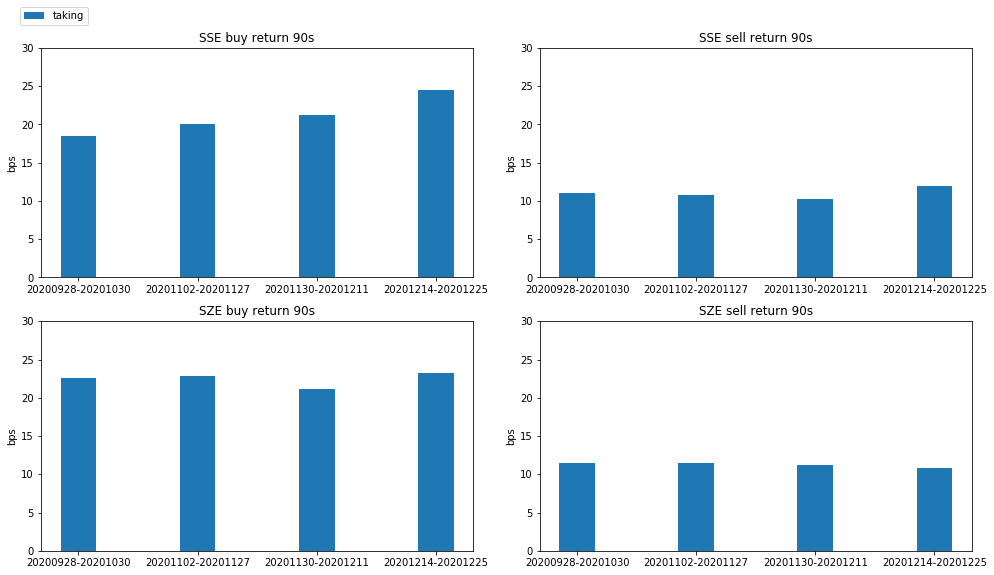

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl   

mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(221)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'taking_order')]['buyRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 90s", fontsize=12)
ax1.legend(loc=1, bbox_to_anchor=(0.12,1.2), bbox_transform=ax1.transAxes)
plt.ylim(0,30)

ax1 = fig.add_subplot(222)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'taking_order')]['sellRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 90s", fontsize=12)
plt.ylim(0,30)

ax1 = fig.add_subplot(223)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'taking_order')]['buyRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'making_order')]['buyAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 90s", fontsize=12)
plt.ylim(0,30)

ax1 = fig.add_subplot(224)
width = 0.3
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'taking_order')]['sellRet'], width = width, label='taking')
# ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['order_type'] == 'making_order')]['sellAlpha'], color='salmon', alpha=1, width=width, label='making')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 90s", fontsize=12)
plt.ylim(0,30)

plt.tight_layout()
plt.show()

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

df = pd.read_pickle(r'L:\orderLog\data.pkl')
tag1 = df.groupby('tag')['date'].min().reset_index()
tag2 = df.groupby('tag')['date'].max().reset_index()
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]

In [2]:
df1 = df.copy()
df1 = df1[df1['tag'] != 'nan']
df1 = df1[df1['ars']%10 == 1]

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange", "index_name"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange", "index_name"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange", "index_name"])["sumsellRet"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange", "index_name"])["sumbuyAlpha"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange", "index_name"])["sumsellAlpha"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange", "index_name"])["sumbuyRet"].transform(sum)

df1["buyRet"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange", "index_name"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange", "index_name"])["sellNum"].transform(sum)

df12 = df1.groupby(["tag", "exchange", "index_name"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().reset_index()

for col in ["buyRet", "buyAlpha", "sellRet", "sellAlpha"]:
    df12[col] = df12[col].apply(lambda x: x*10000)
df12 = df12.sort_values(by='tag') 

from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange", "index_name"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())   

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


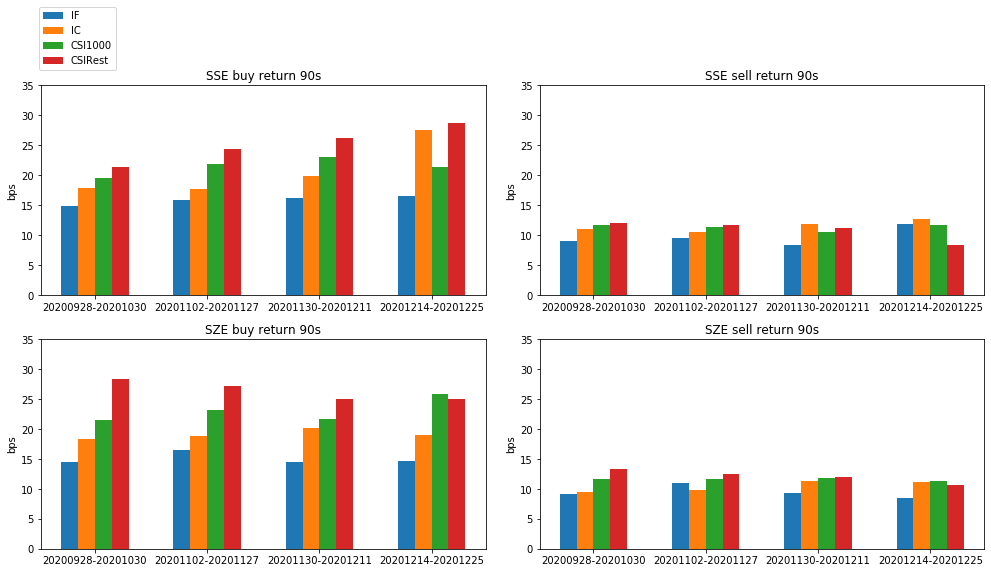

In [3]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(221)
width = 0.15
ax1.bar(np.arange(4)-1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IF')]['buyRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IC')]['buyRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSI1000')]['buyRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSIRest')]['buyRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 90s", fontsize=12)
ax1.legend(loc=1, bbox_to_anchor=(0.18, 1.4), bbox_transform=ax1.transAxes)
plt.ylim(0,35)

ax1 = fig.add_subplot(222)
width = 0.15
ax1.bar(np.arange(4)-1.5 * width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IF')]['sellRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'IC')]['sellRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSI1000')]['sellRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5*width, df2[(df2['exchange'] == 'SSE') & (df2['index_name'] == 'CSIRest')]['sellRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 90s", fontsize=12)
plt.ylim(0,35)

ax1 = fig.add_subplot(223)
width = 0.15
ax1.bar(np.arange(4)-1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IF')]['buyRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IC')]['buyRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSI1000')]['buyRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSIRest')]['buyRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 90s", fontsize=12)
plt.ylim(0,35)

ax1 = fig.add_subplot(224)
width = 0.15
ax1.bar(np.arange(4)-1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IF')]['sellRet'], width = width, label='IF')
ax1.bar(np.arange(4)-width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'IC')]['sellRet'], alpha=1, width=width, label='IC')
ax1.bar(np.arange(4)+width/2, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSI1000')]['sellRet'], width = width, label='CSI1000')
ax1.bar(np.arange(4)+1.5*width, df2[(df2['exchange'] == 'SZE') & (df2['index_name'] == 'CSIRest')]['sellRet'], alpha=1, width=width, label='CSIRest')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 90s", fontsize=12)
plt.ylim(0,35)

plt.tight_layout()
plt.show()

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

df = pd.read_pickle(r'L:\orderLog\data.pkl')
tag1 = df.groupby('tag')['date'].min().reset_index()
tag2 = df.groupby('tag')['date'].max().reset_index()
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]

In [2]:
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', np.where(
df['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
display(df[df['sta'] == 'else'])
df1 = df.copy()

df1 = df1[df1['ars']//1%10 == 1]
df1 = df1[df1['tag'] != 'nan']

dl = df1[df1['sta'] == '3. sta300']['date'].unique()
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 1, -1)
df11 = df1[~df1['date'].isin(dl)]
df12 = df1[df1['date'].isin(dl)]
df12['sta1'] = np.where(df12['sta'].isin(['1. staone', '2. statwo']), 1, 2)
df12['cc'] = df12.groupby(['date', 'exchange', 'Side', 'secid'])['sta1'].transform('nunique')
df12 = df12[df12['cc'] == 2]
df11['cc'] = df11.groupby(['date', 'exchange', 'Side', 'secid'])['sta'].transform('nunique')
df11 = df11[df11['cc'] == 2]
df1 = pd.concat([df11, df12])

df1['tradeNtl'] = df1['tradePrice']*df1['absFilledThisUpdate']
df1["buyNtl"] = np.where(~df1["buyRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sellNtl"] = np.where(~df1["sellRet"].isnull(), df1["tradeNtl"], np.nan)
df1["sumbuyNtl"] = df1.groupby(["tag", "exchange","sta"])["buyNtl"].transform(sum)
df1["sumsellNtl"] = df1.groupby(["tag", "exchange","sta"])["sellNtl"].transform(sum)
    
df1["sumsellRet"] = df1["tradeNtl"] * df1["sellRet"]
df1["sumsellRet"] = df1.groupby(["tag", "exchange","sta"])["sumsellRet"].transform(sum)
df1["sumsellRet1"] = df1["tradeNtl"] * df1["sellRet1"]
df1["sumsellRet1"] = df1.groupby(["tag", "exchange","sta"])["sumsellRet1"].transform(sum)
    
df1["sumbuyAlpha"] = df1["tradeNtl"] * df1["buyAlpha"]
df1["sumbuyAlpha"] = df1.groupby(["tag", "exchange","sta"])["sumbuyAlpha"].transform(sum)
df1["sumbuyAlpha1"] = df1["tradeNtl"] * df1["buyAlpha1"]
df1["sumbuyAlpha1"] = df1.groupby(["tag", "exchange","sta"])["sumbuyAlpha1"].transform(sum)
    
df1["sumsellAlpha"] = df1["tradeNtl"] * df1["sellAlpha"]
df1["sumsellAlpha"] = df1.groupby(["tag", "exchange","sta"])["sumsellAlpha"].transform(sum)
df1["sumsellAlpha1"] = df1["tradeNtl"] * df1["sellAlpha1"]
df1["sumsellAlpha1"] = df1.groupby(["tag", "exchange","sta"])["sumsellAlpha1"].transform(sum)
    
df1["sumbuyRet"] = df1["tradeNtl"] * df1["buyRet"]
df1["sumbuyRet"] = df1.groupby(["tag", "exchange","sta"])["sumbuyRet"].transform(sum)
df1["sumbuyRet1"] = df1["tradeNtl"] * df1["buyRet1"]
df1["sumbuyRet1"] = df1.groupby(["tag", "exchange","sta"])["sumbuyRet1"].transform(sum)

df1["buyRet_90s"] = df1["sumbuyRet"] / df1["sumbuyNtl"]
df1["sellRet_90s"] = df1["sumsellRet"] / df1["sumsellNtl"]
df1["buyAlpha_90s"] = df1["sumbuyAlpha"] / df1["sumbuyNtl"]
df1["sellAlpha_90s"] = df1["sumsellAlpha"] / df1["sumsellNtl"]
df1["buyRet_300s"] = df1["sumbuyRet1"] / df1["sumbuyNtl"]
df1["sellRet_300s"] = df1["sumsellRet1"] / df1["sumsellNtl"]
df1["buyAlpha_300s"] = df1["sumbuyAlpha1"] / df1["sumbuyNtl"]
df1["sellAlpha_300s"] = df1["sumsellAlpha1"] / df1["sumsellNtl"]
df1["buyOrderNum"] = df1.groupby(["tag", "exchange","sta"])["buyNum"].transform(sum)
df1["sellOrderNum"] = df1.groupby(["tag", "exchange","sta"])["sellNum"].transform(sum)

df12 = df1.groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellOrderNum", "sellRet_90s", "sellRet_300s", 
                              "sellAlpha_90s",  "sellAlpha_300s"].first().reset_index()

for col in ["buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellRet_90s", "sellRet_300s", "sellAlpha_90s",  "sellAlpha_300s"]:
    df12[col] = df12[col].apply(lambda x: x*10000)
df12 = df12.sort_values(by='tag') 

from IPython.display import display, HTML
for col in ["buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellRet_90s", "sellRet_300s", "sellAlpha_90s",  "sellAlpha_300s"]:
    df1[col] = df1[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df1.groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyRet_300s", "buyAlpha_90s", "buyAlpha_300s", "sellOrderNum", "sellRet_90s", "sellRet_300s", 
                              "sellAlpha_90s",  "sellAlpha_300s"].first().to_html())

,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrss,mrm,mrsb,orderPrice,l4tr,mrb100,mra100,ApplSeqNum,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,max_trade,last,buyRet,buyRet1,sellRet,...,clock,mrstaat,mrss90,mrstauc,mrsb90,mrsb300,mrss300,mrstaum,mrrlma,cumSharesBought,cumSharesBuyInserted,cumSharesSellInserted,cumSharesSold,gfe,insertedShortOrder,insertionPending,inv_L,inv_L0,inv_S,inv_S0,locateShares,locateSharesTotal,mrv,mv,orderOutstanding,totalActions,totalCanceled,zipFile,test,mrm25,mrmum,l4algoDebug,caa_orderLog,start_time,Price,OrderQty,Side,statusLs,TradePriceLs,TradeQtyLs,resa,m1,m2,index_name,week,num,week1,tag,exchange,sta


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [73]:
df12[(df12['exchange'] == 'SZE') & (df12['sta'] == '3. sta300') & (df12['orderDirection'].isin([1, 2])) & \
     (df12['secid'].isin(df12[(df12['exchange'] == 'SZE') & (df12['sta'] == '2. statwo') & \
                              (df12['orderDirection'].isin([1, 2]))]['secid'].unique()))]['tradeNtl'].describe().astype(int)

count      64358
mean       25829
std        54147
min            2
25%         4216
50%        10131
75%        25121
max      1816992
Name: tradeNtl, dtype: int32

In [74]:
df12[(df12['exchange'] == 'SZE') & (df12['sta'] == '2. statwo') & (df12['orderDirection'].isin([1, 2]))]['tradeNtl'].describe().astype(int)

count     547454
mean       25576
std        53023
min            4
25%         4110
50%        10164
75%        25800
max      3383100
Name: tradeNtl, dtype: int32

In [34]:
HTML(df1[(df1['exchange'] == 'SSE')].groupby(["tag", "exchange","sta"])["buyOrderNum", "buyRet_90s", "buyAlpha_90s"].first().to_html())

In [50]:
df12['tradeNtl'] = df12['tradePrice'] * df12['absFilledThisUpdate']
df12[(df12['sta'] == '2. statwo') & (df12['exchange'] == 'SSE') & (df12['Side'] == 1) & (df12['tag'] == '4. current week')].groupby('index_name')['tradeNtl'].sum()

index_name
CSI1000    9.269022e+08
CSIRest    1.120109e+09
IC         1.568153e+09
Name: tradeNtl, dtype: float64

In [51]:
df12['tradeNtl'] = df12['tradePrice'] * df12['absFilledThisUpdate']
df12[(df12['sta'] == '1. staone') & (df12['exchange'] == 'SSE') & (df12['Side'] == 1) & (df12['tag'] == '4. current week')].groupby('index_name')['tradeNtl'].sum()

index_name
CSI1000    43635258.86
CSIRest    63533412.85
IC         65563717.48
Name: tradeNtl, dtype: float64

In [53]:
df12['tradeNtl'] = df12['tradePrice'] * df12['absFilledThisUpdate']
df12[(df12['sta'] == '3. sta300') & (df12['exchange'] == 'SSE') & (df12['Side'] == 1) & (df12['tag'] == '4. current week')].groupby('index_name')['tradeNtl'].sum()

index_name
CSI1000    2.174208e+08
CSIRest    8.911309e+07
IC         9.499960e+07
Name: tradeNtl, dtype: float64

In [49]:
df12['tradeNtl'] = df12['tradePrice'] * df12['absFilledThisUpdate']
df12[(df12['sta'] == '1. staone') & (df12['exchange'] == 'SSE') & (df12['Side'] == 1) & (df12['tag'] == '4. current week')].groupby('index_name')['tradeNtl'].sum()

index_name
CSI1000    43635258.86
CSIRest    63533412.85
IC         65563717.48
Name: tradeNtl, dtype: float64

In [48]:
df12['tradeNtl'] = df12['tradePrice'] * df12['absFilledThisUpdate']
df12[(df12['sta'] == '1. staone') & (df12['exchange'] == 'SSE') & (df12['Side'] == 1) & (df12['tag'] == '3. previous two weeks')].groupby('index_name')['tradeNtl'].sum()

index_name
CSI1000    3.201781e+08
CSIRest    5.673743e+07
IC         3.943052e+08
Name: tradeNtl, dtype: float64

In [29]:
df12['tradeNtl'] = df12['tradePrice'] * df12['absFilledThisUpdate']
df12[(df12['sta'] == '2. statwo') & (df12['exchange'] == 'SSE') & (df12['Side'] == 1) & (df12['tag'] == '4. current week')]['buyAlpha'].describe()

count    114355.000000
mean          0.001771
std           0.003651
min          -0.026594
25%          -0.000182
50%           0.001184
75%           0.003058
max           0.040867
Name: buyAlpha, dtype: float64

In [125]:
(df[(df['sta'] == '1. staone') & (df['tag'] == '3. previous two weeks') & 
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))  & (df['index_name'].isin(['CSI1000', 'CSIRest'])) & (df['colo'].isin(['zs_96_06', 'zt_88_03', 'zs_52_06', 'zs_52_09', 'zs_66_01']))].groupby(['date', 'accCode'])['sellAlpha'].describe() * 10000).fillna(0).astype('int64')

count  mean  std   min  25%  50%  75%  max
date     accCode                                               
20201026 5222       880000    -2   27   -95  -14    1   11   44
         5225     17310000    20  142 -1228  -42   25   84  616
         5226       850000     0   26   -95  -10    5   16   55
         5230      1120000     5   20   -79   -4    8   15   54
         5269       730000   -23   34   -92  -48  -16    9   39
...                    ...   ...  ...   ...  ...  ...  ...  ...
20201106 6634      9200000    14  129  -527  -26   21   82  306
         6683       910000   -11   59  -161   -5    1   11  105
         8833      1140000   -23  164  -919  -51    1   39  259
         9756        40000   499   23   464  499  511  511  511
         9758      3870000     3  129 -1078  -30    3   56  313

[169 rows x 8 columns]

In [126]:
(df[(df['sta'] == '1. staone') & (df['tag'] == '4. current week') & 
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2])) & (df['index_name'].isin(['CSI1000', 'CSIRest'])) & (df['colo'].isin(['zs_96_06', 'zt_88_03', 'zs_52_06', 'zs_52_09', 'zs_66_01']))].groupby(['date', 'colo', 'accCode'])['sellAlpha'].describe() * 10000).fillna(0).astype('int64')

count  mean  std  min  25%  50%  75%   max
date     colo     accCode                                               
20201109 zs_52_06 5222      4370000     6   31 -255   -1    5   13   110
                  5269      1500000   -45  115 -300  -25    0   15   137
                  5273     23840000     2   99 -803  -22    6   45  1250
                  5275     14570000    17   53 -180   -6   10   38   238
                  5287      4180000     5   14  -52   -2    5   13    63
         zs_52_09 5225     11510000    11  122 -795  -27   11   65  1250
                  5226      3240000     2   45 -255    0    4   14   102
                  5230      6120000     8   21  -57    0    5   15   129
                  5290      6420000     9   24  -57    0    5   15   137
         zs_66_01 6623      3670000     6   13  -52   -2    5   13    61
                  6627      3690000     6   14  -52   -2    5   15    49
                  6631     11580000     9  139 -437  -46    6   66  1464
                  6634     12290000    10  118 -428  -44   12   67  1374
                  6683      3790000     6   18  -64    0    5   12    72
         zs_96_06 9756       110000    96   21   81   81   81  121   125
                  9758      4450000     9   70 -180  -19   11   32   215
         zt_88_03 8833      1500000     3   58 -174  -12    4   29   176
20201110 zs_52_06 5222      1010000    -1   19  -69  -12    0   10    64
                  5269      1090000     0   23  -71   -7    2    7    64
                  5273     20210000    21   92 -326  -10   19   60   383
                  5275     15180000    25   92 -231  -20   14   62   580
                  5287      1150000    10   18  -35   -2    6   21    51
         zs_52_09 5225     12500000    30   84 -324   -8   19   67   365
                  5226      1210000     5   20  -69   -4    3   12    64
                  5230      1810000     4   25  -86   -6    5   17    79
                  5290      1320000     4   22  -86   -8    4   15    64
         zs_66_01 6623       660000    10   14  -18   -2    6   21    50
                  6627       580000    16   20  -28    4   11   41    43
                  6631      7960000    19  104 -528  -19   17   69   364
                  6634      6620000     4  138 -590  -60   16   75   364
                  6683      1000000     7   20  -54   -4   10   21    43
         zs_96_06 9758      4550000    17  105 -190  -52    9   69   411
         zt_88_03 8833      1520000    14   65 -176  -21    7   51   187
20201111 zs_52_06 5222      1040000     5   21  -45   -4    1    9    98
                  5269       220000    15   16  -27   12   16   22    49
                  5273     17220000     1   99 -415  -32   12   50   433
                  5275     13800000    21   55 -158   -7   14   46   265
                  5287       580000     6   40  -85   -3    2   13   131
         zs_52_09 5225     10550000    11   85 -415  -26   16   54   433
                  5226       640000     3   13  -19   -2    1    5    61
                  5230      1120000     2   19  -64   -4    0   12    70
                  5290      1200000     7   26  -60   -2    4   21    98
         zs_66_01 6623      1190000    16   33  -85    1    4   21   113
                  6627      1170000    13   29  -25   -2    3   17   131
                  6631     11970000     5   90 -270  -56   13   55   401
                  6634     11620000    25   84 -284  -12   30   73   479
                  6683      1260000     9   37  -85   -2    5   15   131
         zs_96_06 9758      3230000    28   52 -172    6   30   60   211
         zt_88_03 8833       880000    29   52  -77    4   24   48   232
20201112 zs_52_06 5222       660000     1   16  -57   -4    3    7    42
                  5269       350000     7   26  -58  -10    4   30    50
                  5273     10280000     5  107 -624  -16   12   49   298
                  5275      8210000    15   66 -165  -13   18   56   248
               

In [138]:
(df[(df['date'] == 20201113) & (df['colo'] == 'zs_66_01') & (df['accCode'] == 6634) & (df['sta'] == '1. staone') &  
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2])) & (df['index_name'].isin(['CSI1000', 'CSIRest'])) & 
    (df['sdd'] <= 93300000)]['sellAlpha'].describe(perc) * 10000).astype(int)

count    8590000
mean          37
std          112
min         -248
1%          -204
5%          -131
10%          -74
25%          -20
50%           29
75%           72
90%          193
95%          267
99%          370
max          370
Name: sellAlpha, dtype: int32

In [160]:
df[(df['date'] == 20201113) & (df['colo'] == 'zs_66_01') & (df['accCode'] == 6634) & (df['sta'] == '1. staone') &  
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2])) & (df['index_name'].isin(['CSI1000', 'CSIRest']))]['sellRet'].describe()

count    1088.000000
mean        0.005109
std         0.010685
min        -0.024456
25%         0.000017
50%         0.003097
75%         0.008415
max         0.041394
Name: sellRet, dtype: float64

In [163]:
df[(df['date'] == 20201109) & (df['colo'] == 'zs_66_01') & (df['accCode'] == 6634) & (df['sta'] == '1. staone') &  
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2])) & (df['index_name'].isin(['CSI1000', 'CSIRest'])) & (df['sellRet'] <= 0.1)]['sellRet'].describe()

count    1226.000000
mean        0.000591
std         0.010060
min        -0.041536
25%        -0.004637
50%         0.000599
75%         0.006466
max         0.039202
Name: sellRet, dtype: float64

In [164]:
df[(df['date'] == 20201109) & (df['colo'] == 'zs_66_01') & (df['accCode'] == 6634) & (df['sta'] == '1. staone') &  
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2])) & (df['index_name'].isin(['CSI1000', 'CSIRest'])) & (df['sellRet'] < -0.04)]

,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,l4tr,internalId,session,cfe,orderId,underlyingIndex,mt,hee,cancellationPending,mfe,threadId,ms,finalState,sequenceNo,clock,mrstaat,mrss90,mrstauc,mrsb90,mrsb300,mrss300,mrstaum,mrrlma,m1,m2,index_name,week,num,week1,tag,exchange,sta
12622892,1.604885e+15,1.604885e+15,2300138.0,4.0,983600.0,1.0,400.0,-1.0,400.0,400.0,19.61,19.61,20201109,6634,0.0,zs_66_01,NaN,1.03e+14,93008190.0,-0.000166,0.0,-0.004835,-1,NaN,NaN,NaN,1959.0,1960.0,105697,0.0,1,613409,1.604885e+15,1000852.0,1.306306,1.604885e+15,1.604885e+15,19.697883,20.457470,21.343077,6735.1141,6730.7157,6728.195,6743.8613,NaN,NaN,-0.041426,-0.081201,-0.001027,0.001299,NaN,NaN,-0.042768,-0.079504,0,1,zs6601_6634,0.0,272.0,0.0,6.370138e+06,1.812800e+10,852.0,-1.0,-1.0,0.0,-1.0,183253.0,09:30:11.565603,1.0,6031281.0,1.604885e+15,1000.0,-0.000166,0.0,-0.001995,-1,-1.0,0.0,0.0,1000.0,0.0,CSIRest,46.0,5,13,4. current week,SZE,1. staone
12622894,1.604885e+15,1.604885e+15,2300138.0,4.0,1043200.0,1.0,1300.0,-1.0,1900.0,1300.0,19.62,19.62,20201109,6634,0.0,zs_66_01,00C0QJI3FI00576U,1.03e+14,93011300.0,-0.000358,0.0,-0.005068,-1,NaN,NaN,NaN,1962.0,1966.0,105699,0.0,1,613546,1.604885e+15,1000852.0,1.306306,1.604885e+15,1.604885e+15,19.937708,20.470242,21.112963,6735.1141,6730.7157,6728.195,6743.7843,NaN,NaN,-0.041536,-0.070713,-0.001027,0.001287,NaN,NaN,-0.042878,-0.069031,0,1,zs6601_6634,0.0,321.0,0.0,7.446353e+06,1.812800e+10,852.0,-1.0,-1.0,0.0,-1.0,183253.0,09:30:13.474603,0.0,6290808.0,1.604885e+15,1000.0,-0.000358,0.0,-0.001683,-1,-1.0,0.0,0.0,1000.0,0.0,CSIRest,46.0,5,13,4. current week,SZE,1. staone
12622895,1.604885e+15,1.604885e+15,2300138.0,4.0,1043200.0,1.0,600.0,-1.0,1900.0,1900.0,19.62,19.62,20201109,6634,0.0,zs_66_01,NaN,1.03e+14,93011300.0,-0.000358,0.0,-0.005068,-1,NaN,NaN,NaN,1962.0,1966.0,105699,0.0,1,613547,1.604885e+15,1000852.0,1.306306,1.604885e+15,1.604885e+15,19.937708,20.470242,21.112963,6735.1141,6730.7157,6728.195,6743.7843,NaN,NaN,-0.041536,-0.070713,-0.001027,0.001287,NaN,NaN,-0.042878,-0.069031,0,1,zs6601_6634,0.0,321.0,0.0,7.458125e+06,1.812800e+10,852.0,-1.0,-1.0,0.0,-1.0,183253.0,09:30:13.474603,1.0,6290808.0,1.604885e+15,1000.0,-0.000358,0.0,-0.001683,-1,-1.0,0.0,0.0,1000.0,0.0,CSIRest,46.0,5,13,4. current week,SZE,1. staone


In [113]:
(df[(df['sta'] == '2. statwo') & (df['tag'] == '4. current week') & 
    (df['exchange'] == 'SZE') & (df['orderDirection'].isin([-1, -2]))].groupby('index_name')['sellAlpha'].describe() * 10000).astype('int64')

,count,mean,std,min,25%,50%,75%,max
index_name,,,,,,,,
CSI1000,1302210000,6,28,-425,-3,5,18,331
CSIRest,1905330000,8,38,-711,-4,7,23,745
IC,867260000,8,26,-326,-2,7,19,407
IF,340540000,6,24,-430,-3,5,18,175


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


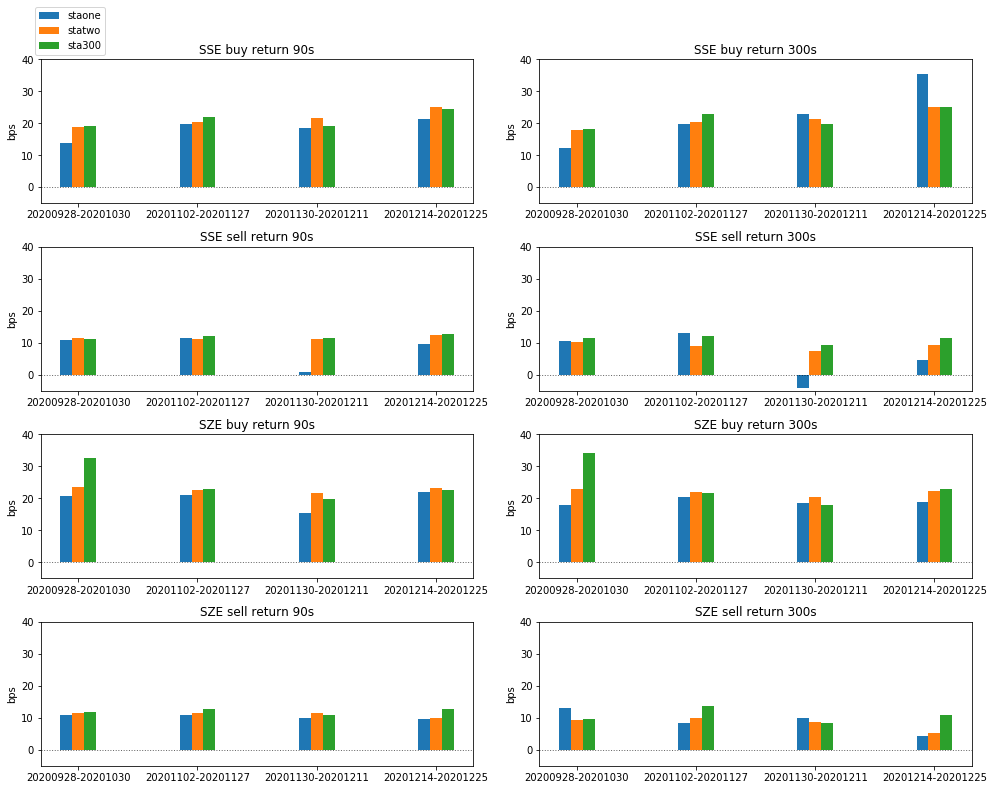

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl   

mpl.rcParams['font.sans-serif'] = ['TimesNewRoman']
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(14, 11))
ax1 = fig.add_subplot(421)
width = 0.1
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['buyRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['buyRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['buyRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 90s", fontsize=12)
ax1.legend(loc=1, bbox_to_anchor=(0.16,1.4), bbox_transform=ax1.transAxes)
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.ylim(-5,40)

ax1 = fig.add_subplot(422)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['buyRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['buyRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['buyRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE buy return 300s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(423)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['sellRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['sellRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['sellRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 90s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(424)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '1. staone')]['sellRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '2. statwo')]['sellRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SSE') & (df2['sta'] == '3. sta300')]['sellRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SSE sell return 300s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(425)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['buyRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['buyRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['buyRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 90s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(426)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['buyRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['buyRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['buyRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE buy return 300s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(427)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['sellRet_90s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['sellRet_90s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['sellRet_90s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 90s", fontsize=12)
plt.ylim(-5,40)

ax1 = fig.add_subplot(428)
ax1.bar(np.arange(4)-width, df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '1. staone')]['sellRet_300s'], width = width, label='staone')
ax1.bar(np.arange(4), df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '2. statwo')]['sellRet_300s'], alpha=1, width=width, label='statwo')
ax1.bar(np.arange(4)+width, list(df2[(df2['exchange'] == 'SZE') & (df2['sta'] == '3. sta300')]['sellRet_300s']), width = width, label='sta300')
ax1.set_ylabel("bps")
ax1.axhline(y=0, color='black', linestyle="dotted", alpha=0.6, linewidth=1)
plt.xticks(np.arange(4), [str(tag1['date'].iloc[0]) + '-' + str(tag2['date'].iloc[0]), str(tag1['date'].iloc[1]) + '-' + str(tag2['date'].iloc[1]),
                          str(tag1['date'].iloc[2]) + '-' + str(tag2['date'].iloc[2]), str(tag1['date'].iloc[3]) + '-' + str(tag2['date'].iloc[3])])
plt.title("SZE sell return 300s", fontsize=12)
plt.ylim(-5,40)

plt.tight_layout()
plt.show()

In [15]:
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1)]
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', np.where(
df['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
df1 = df.copy()
df1['aaa'] = df1['aaa'] * 10000
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 'Buy', 'Sell')
re = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['aaa'].describe().reset_index()
re1 = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['buyNum'].sum().reset_index()
re1 = re1[re1['Side'] == 'Buy']
re1 = re1.rename(columns={'buyNum':'num'})
re2 = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['sellNum'].sum().reset_index()
re2 = re2[re2['Side'] == 'Sell']
re2 = re2.rename(columns={'sellNum':'num'})
ree = pd.concat([re1, re2])
re = re[['Side', 'exchange', 'sta', 'mean', 'std', 'min', '50%', 'max']]
re = pd.merge(re, ree, on=['Side', 'exchange', 'sta'])
re = re[['Side', 'exchange', 'sta', 'num', 'mean', 'std', 'min', '50%', 'max']]
for i in ['mean', 'std', 'min', '50%', 'max']:
    re[i] = re[i].apply(lambda x: '%.1f'%(x))
re['num'] = re['num'].astype(int)
HTML(re.groupby(['Side', 'exchange', 'sta'])['num', 'mean', 'std', 'min', '50%', 'max'].first().to_html())

In [23]:
# df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
# df = df[(df['ars']%10 == 1)]
# df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
# df['mrstaat'] == 3000, '2. statwo', np.where(
# df['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
df1 = df.copy()
df1['aaa'] = df1['aaa'] * 10000
df1['buyRet'] = df1['buyRet'] * 10000
df1['sellRet'] = df1['sellRet'] * 10000
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 'Buy', 'Sell')
# aaa每个order里一样，只看最后一个tick的还是看所有的

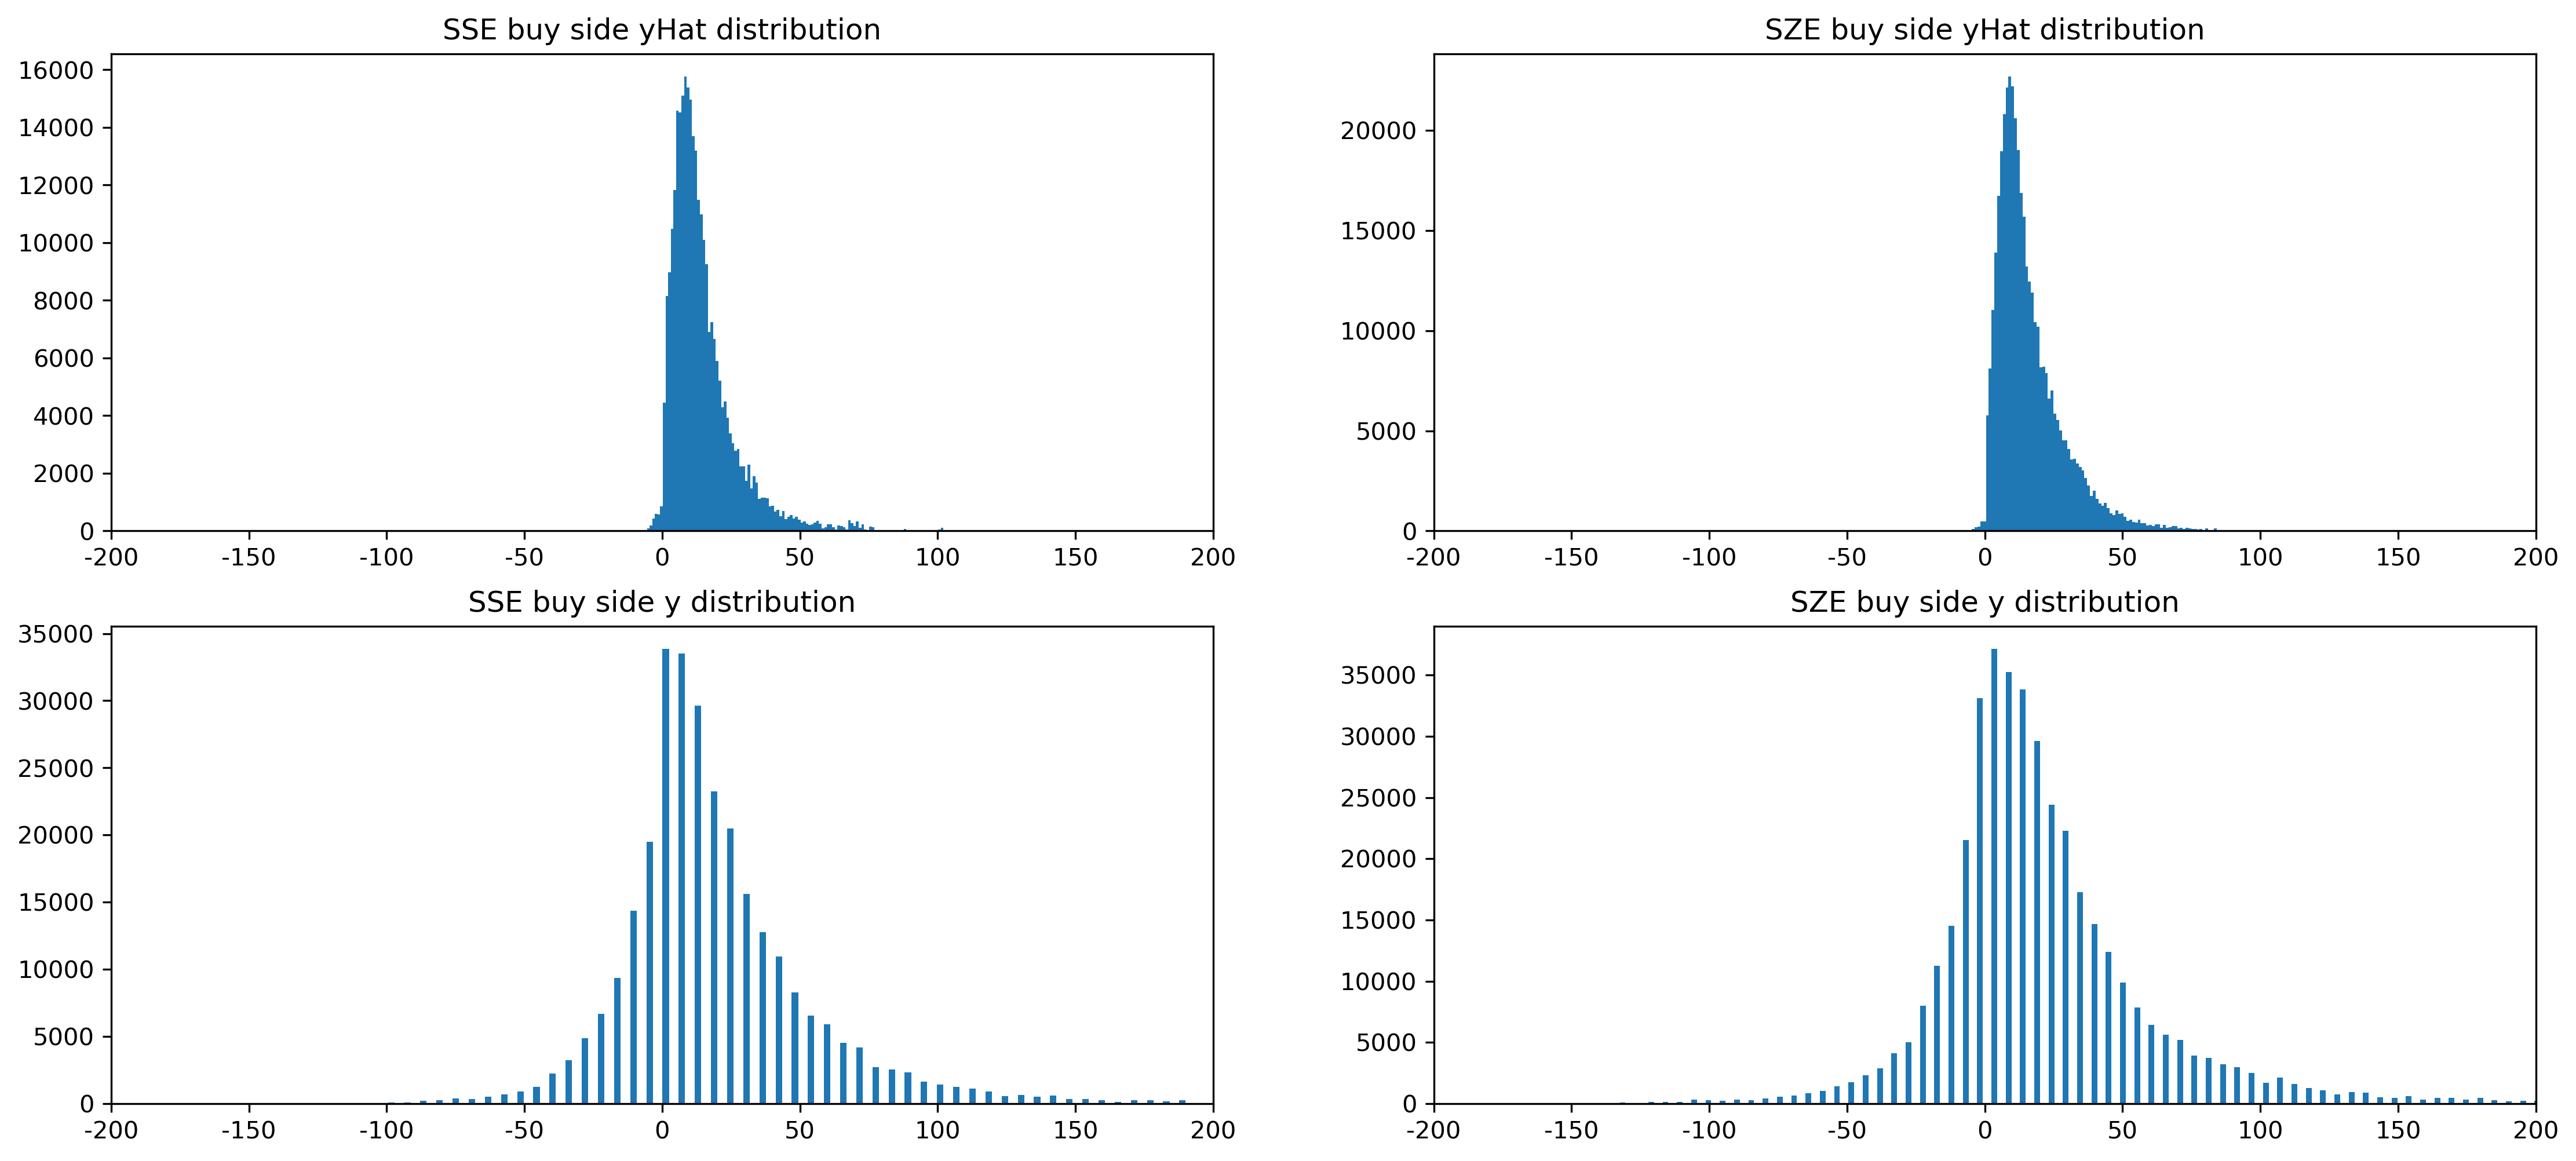

In [36]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(221)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SSE') & (df1['Side'] == 'Buy')]['aaa'].values, bins=200)
plt.title('SSE buy side yHat distribution')
ax1.set_xlim(-200, 200)

ax1 = fig.add_subplot(222)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SZE') & (df1['Side'] == 'Buy')]['aaa'].values, bins=200)
plt.title('SZE buy side yHat distribution')
ax1.set_xlim(-200, 200)

ax1 = fig.add_subplot(223)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SSE')]['buyRet'].values, bins=200, rwidth=0.4)
plt.title('SSE buy side y distribution')
ax1.set_xlim(-200, 200)

ax1 = fig.add_subplot(224)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SZE')]['buyRet'].values, bins=200, rwidth=0.4)
plt.title('SZE buy side y distribution')
ax1.set_xlim(-200, 200)

# plt.rcParams["figure.dpi"] = 300
plt.show()

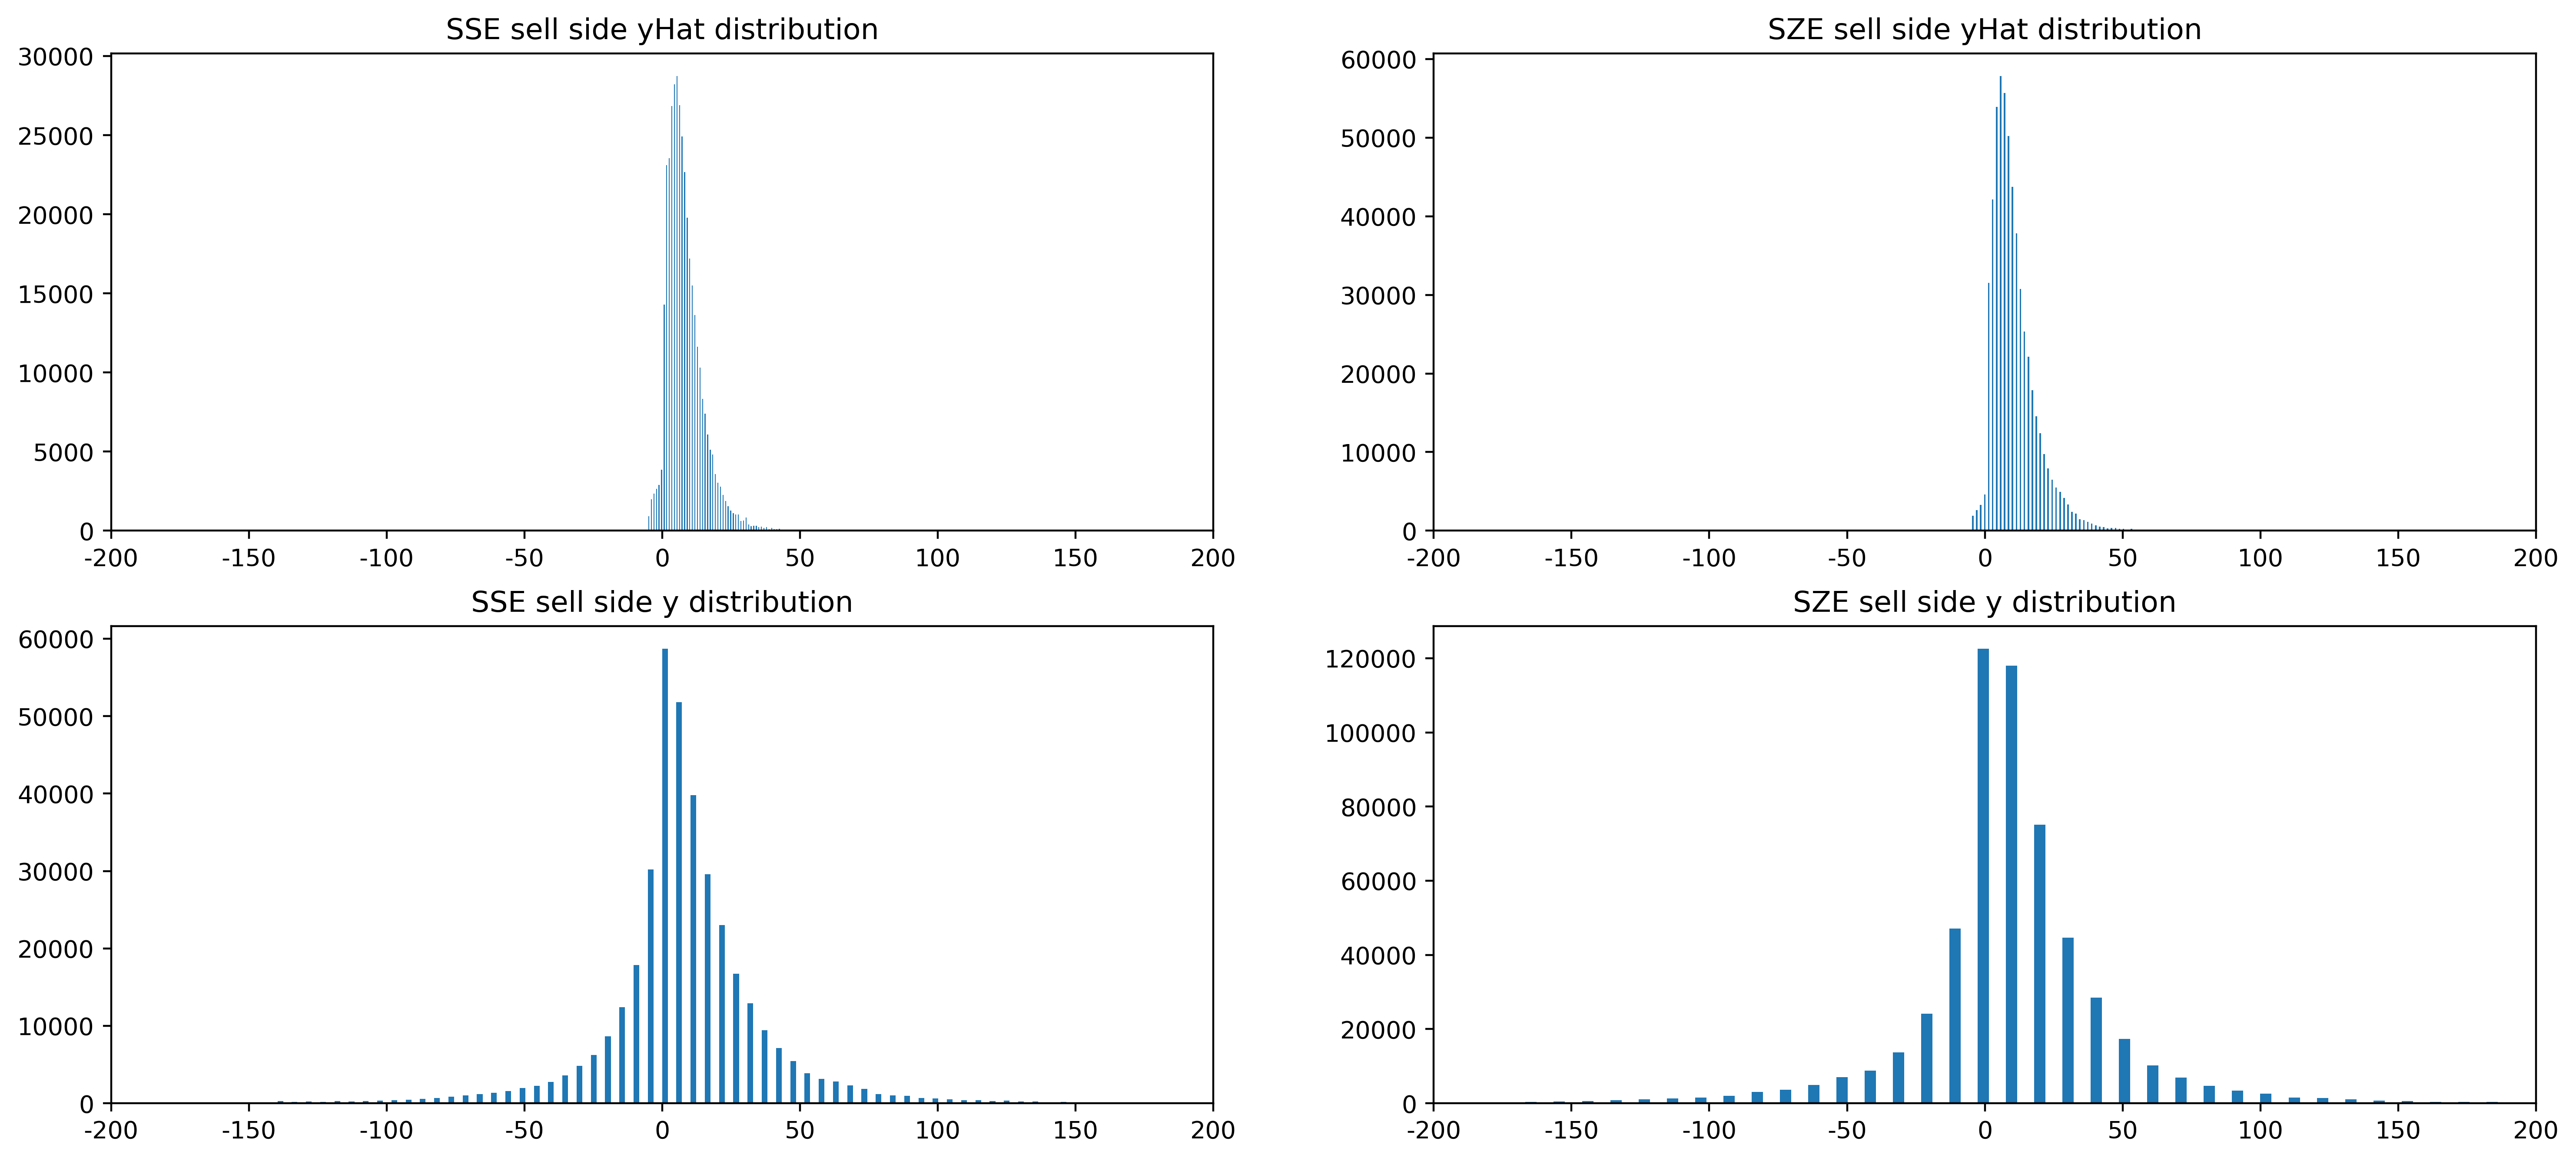

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import io

def display_figure(fig=None):
    if not fig: fig=plt.gcf();
    buff = io.BytesIO()
    fig.savefig(buff, dpi=288)
    buff.seek(0)
    display(Image(data=buff.getvalue(), width=480))
    
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(221)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SSE') & (df1['Side'] == 'Sell')]['aaa'].values, bins=200, rwidth=0.4)
plt.title('SSE sell side yHat distribution')
ax1.set_xlim(-200, 200)

ax1 = fig.add_subplot(222)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SZE') & (df1['Side'] == 'Sell')]['aaa'].values, bins=200, rwidth=0.4)
plt.title('SZE sell side yHat distribution')
ax1.set_xlim(-200, 200)

ax1 = fig.add_subplot(223)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SSE')]['sellRet'].values, bins=200, rwidth=0.4)
plt.title('SSE sell side y distribution')
ax1.set_xlim(-200, 200)

ax1 = fig.add_subplot(224)
plt.hist(df1[(df1['tag'] == '4. current week') & (df1['exchange'] == 'SZE')]['sellRet'].values, bins=200, rwidth=0.4)
plt.title('SZE sell side y distribution')
ax1.set_xlim(-200, 200)

# display_figure(plt.gcf())
plt.rcParams["figure.dpi"] = 300
plt.show()

In [20]:
df1 = df.copy()
df1['buyRet'] = df1['buyRet'] * 10000
df1['sellRet'] = df1['sellRet'] * 10000
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 'Buy', 'Sell')
re = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['buyRet'].describe().reset_index()
re1 = re[re['Side'] == 'Buy']
re = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['sellRet'].describe().reset_index()
re2 = re[re['Side'] == 'Sell']
re = pd.concat([re1, re2])
re1 = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['buyNum'].sum().reset_index()
re1 = re1[re1['Side'] == 'Buy']
re1 = re1.rename(columns={'buyNum':'num'})
re2 = df1[df1['tag'] == '4. current week'].groupby(['Side', 'exchange', 'sta'])['sellNum'].sum().reset_index()
re2 = re2[re2['Side'] == 'Sell']
re2 = re2.rename(columns={'sellNum':'num'})
ree = pd.concat([re1, re2])
re = re[['Side', 'exchange', 'sta', 'mean', 'std', 'min', '50%', 'max']]
re = pd.merge(re, ree, on=['Side', 'exchange', 'sta'])
re = re[['Side', 'exchange', 'sta', 'num', 'mean', 'std', 'min', '50%', 'max']]
for i in ['mean', 'std', 'min', '50%', 'max']:
    re[i] = re[i].apply(lambda x: '%.1f'%(x))
re['num'] = re['num'].astype(int)
HTML(re.groupby(['Side', 'exchange', 'sta'])['num', 'mean', 'std', 'min', '50%', 'max'].first().to_html())

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

import pymongo
import pandas as pd
import numpy as np
import pickle
import datetime
import time
import gzip
import lzma
import pytz

df = pd.read_pickle(r'L:\orderLog\data.pkl')
tag1 = df.groupby('tag')['date'].min().reset_index()
tag2 = df.groupby('tag')['date'].max().reset_index()
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df = df[(df['ars']%10 == 1) | (df['ars']%10 == 2)]

In [2]:
df['exchange'] = np.where(df['secid'] >= 2000000, 'SZE', 'SSE')
df['sta'] = np.where(df['mrstaat'] == 1000, '1. staone', np.where(
df['mrstaat'] == 3000, '2. statwo', np.where(
df['mrstaat'].isin([11000, 13000]), '3. sta300', 'else')))
df1 = df[df['tag'] == '4. current week']
df1 = df1[(df1['ars']%10 == 1)]
df1['aaa'] = df1['aaa'] * 10000
df1['buyRet'] = df1['buyRet'] * 10000
df1['sellRet'] = df1['sellRet'] * 10000
df1['buyRet1'] = df1['buyRet1'] * 10000
df1['sellRet1'] = df1['sellRet1'] * 10000
df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 'Buy', 'Sell')
p1 = df1[['Side', 'exchange', 'sta', 'buyRet', 'sellRet', 'buyNum', 'sellNum']]
p1['return'] = np.where(p1['Side'] == 'Buy', p1['buyRet'], p1['sellRet'])
p1['tag'] = '2. F90s return'
p2 = df1[['Side', 'exchange', 'sta', 'buyRet1', 'sellRet1', 'buyNum', 'sellNum']]
p2['tag'] = '3. F300s return'
p2['return'] = np.where(p2['Side'] == 'Buy', p2['buyRet1'], p2['sellRet1'])
p3 = df1[['Side', 'exchange', 'sta', 'aaa', 'buyNum', 'sellNum']]
p3['tag'] = '1. yHat'
p3 = p3.rename(columns={'aaa':'return'})
df1 = pd.concat([p1, p2, p3])

re = df1.groupby(['Side', 'exchange', 'sta', 'tag'])['return'].describe().reset_index()
re1 = df1.groupby(['Side', 'exchange', 'sta', 'tag'])['buyNum'].sum().reset_index()
re1 = re1[re1['Side'] == 'Buy']
re1 = re1.rename(columns={'buyNum':'num'})
re2 = df1.groupby(['Side', 'exchange', 'sta', 'tag'])['sellNum'].sum().reset_index()
re2 = re2[re2['Side'] == 'Sell']
re2 = re2.rename(columns={'sellNum':'num'})
ree = pd.concat([re1, re2])
re = re[['Side', 'exchange', 'sta', 'tag', 'mean', 'std', 'min', '50%', 'max']]
re = pd.merge(re, ree, on=['Side', 'exchange', 'sta', 'tag'])
re = re[['Side', 'exchange', 'sta', 'tag', 'num', 'mean', 'std', 'min', '50%', 'max']]
for i in ['mean', 'std', 'min', '50%', 'max']:
    re[i] = re[i].apply(lambda x: '%.1f'%(x))
re['num'] = re['num'].astype(int)
re = re.sort_values(by=['Side', 'exchange', 'sta', 'num','tag'])
re.index = pd.MultiIndex.from_arrays([list(re['Side'].values), list(re['exchange'].values), list(re['sta'].values), list(re['num'].values), list(re['tag'].values)],
                                            names=['Side', 'exchange', 'sta', 'num','tag'])
re.index = pd.MultiIndex.from_tuples([(x[0], x[1], x[2][3:], x[3], x[4][3:]) for x in re.index],
                                            names=['Side', 'exchange', 'sta', 'num','tag'])
from IPython.display import display, HTML
HTML(re[['mean', 'std', 'min', '50%', 'max']].to_html())

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [25]:
pd.set_option('max_rows', 200)
df[(df['sellRet'] == df['sellRet1']) & (df['date'] == 20201127) & (df['secid'] == 1600433)]

,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,order,firstUpdateType,insertNum,innerSeq,firstClock,indexCat,beta_60,mdStartClock,mdClockAtArrival,adjMid_F30s,adjMid_F90s,adjMid_F300s,indexClose,indexClose_F30s,indexClose_F90s,indexClose_F300s,max_trade,last,buyRet,buyRet1,sellRet,sellRet1,indexRet,indexRet1,buyAlpha,buyAlpha1,sellAlpha,sellAlpha1,buyNum,sellNum,server_account,session,cfe,orderId,underlyingIndex,mt,hee,cancellationPending,mfe,threadId,ms,finalState,sequenceNo,clock,mrstaat,mrss90,mrstauc,mrsb90,mrsb300,mrss300,mrstaum,mrrlma,test,t1,mrmum,mrm25,cumSharesBought,cumSharesBuyInserted,cumSharesSellInserted,cumSharesSold,gfe,insertedShortOrder,insertionPending,inv_L,inv_L0,inv_S,inv_S0,locateShares,locateSharesTotal,mv,orderOutstanding,totalActions,totalCanceled,zipFile,m1,m2,index_name,week,num,week1,tag,exchange,sta
16017862,1.606442e+15,1.606442e+15,1600433.0,4.0,17450951.0,1.0,1200.0,-1.0,3600.0,1200.0,4.05,4.05,20201127,527701,0.0,zt_52_07,88876,2.0,4.98348e+06,95750000.0,0.000992,NaN,-0.005041,-1,NaN,NaN,17450951.0,405.0,406.0,0.0,193500,0.0,1,370587,1.606442e+15,1000852.0,0.857636,1.606442e+15,1.606442e+15,4.039316,4.17,4.17,6633.3491,6635.7131,6633.6309,6636.1727,3600.0,0,NaN,NaN,-0.028777,-0.028777,0.000042,0.000426,NaN,NaN,-0.028741,-0.028412,0,0,zt5207_527701,0.0,2749234.80,8.887600e+04,852.0,-1.0,-1,0.0,-1.0,421940.0,09:58:03.875623,0.0,35462637.0,1.606442e+15,3000.0,0.000992,1000.0,-0.003153,-1,-1.0,0.0,0.0,193111.0,NaN,0.0,0.0,0.0,0.0,3600.0,1200.0,2749233.80,0.0,0.0,141600.0,0.0,0.0,0.0,0.0,0.0,1.651681e+08,1.0,5.0,0.0,logs_20201127_zt_52_07_day_527701,3000.0,1000.0,CSIRest,48.0,5,11,4. current week,SSE,2. statwo
16017863,1.606442e+15,1.606442e+15,1600433.0,4.0,17450951.0,1.0,2400.0,-1.0,3600.0,3600.0,4.05,4.05,20201127,527701,0.0,zt_52_07,NaN,2.0,4.98662e+06,95750000.0,0.000992,NaN,-0.005041,-1,NaN,NaN,17453451.0,405.0,406.0,0.0,193500,0.0,1,370612,1.606442e+15,1000852.0,0.857636,1.606442e+15,1.606442e+15,4.039316,4.17,4.17,6633.3491,6635.7131,6633.6309,6636.1727,3600.0,1,NaN,NaN,-0.028777,-0.028777,0.000042,0.000426,NaN,NaN,-0.028741,-0.028412,0,1,zt5207_527701,0.0,3573876.50,8.887600e+04,852.0,-1.0,-1,0.0,-1.0,421940.0,09:58:05.764623,1.0,35466986.0,1.606442e+15,3000.0,0.000992,1000.0,-0.003153,-1,-1.0,0.0,0.0,193111.0,NaN,0.0,0.0,0.0,0.0,3600.0,3600.0,3573875.50,0.0,0.0,139200.0,0.0,0.0,0.0,0.0,0.0,1.646254e+08,0.0,9.0,0.0,logs_20201127_zt_52_07_day_527701,3000.0,1000.0,CSIRest,48.0,5,11,4. current week,SSE,2. statwo
16017864,1.606442e+15,1.606442e+15,1600433.0,4.0,17476351.0,1.0,1800.0,-1.0,3300.0,1800.0,4.05,4.05,20201127,527701,0.0,zt_52_07,89047,18.0,4.9948e+06,95756000.0,0.000616,NaN,-0.005041,-1,NaN,NaN,17476351.0,405.0,406.0,0.0,193501,0.0,1,370647,1.606442e+15,1000852.0,0.857636,1.606442e+15,1.606442e+15,4.050986,4.17,4.17,6634.2044,6635.8925,6633.7458,6635.9164,3300.0,0,NaN,NaN,-0.028777,-0.028777,-0.000069,0.000258,NaN,NaN,-0.028836,-0.028556,0,0,zt5207_527701,0.0,3806369.90,8.904700e+04,852.0,-1.0,-1,0.0,-1.0,421940.0,09:58:09.951623,0.0,35545722.0,1.606442e+15,3000.0,0.000616,2000.0,-0.002784,-1,-1.0,0.0,0.0,193110.0,NaN,0.0,0.0,0.0,0.0,6900.0,5400.0,3806368.90,0.0,0.0,137400.0,0.0,0.0,0.0,0.0,0.0,1.642113e+08,1.0,20.0,1.0,logs_20201127_zt_52_07_day_527701,3000.0,2000.0,CSIRest,48.0,5,11,4. current week,SSE,2. statwo
16017865,1.606442e+15,1.606442e+15,1600433.0,4.0,17476351.0,1.0,1500.0,-1.0,3300.0,3300.0,4.05,4.05,20201127,527701,0.0,zt_52_07,NaN,18.0,4.99504e+06,95756000.0,0.000616,NaN,-0.005041,-1,NaN,NaN,17476351.0,405.0,406.0,0.0,193501,0.0,1,370649,1.606442e+15,1000852.0,0.857636,1.606442e+15,1.606442e+15,4.050986,4.17,4.17,6634.2044,6635.8925,6633.7458,6635.9164,3300.0,1,NaN,NaN,-0.028777,-0.028777,-0.000069,0.000258,NaN,NaN,-0.028836,-0.028556,0,1,zt5207_527701,0.0,3842994.90,8

In [35]:
df1[(df1['sellRet1'] < -611) & (df1['exchange'] == 'SSE') & (df1['sta'] == '3. sta300')]

,Side,buyNum,buyRet,buyRet1,exchange,return,sellNum,sellRet,sellRet1,sta,tag
14890760,Sell,0,NaN,NaN,SSE,-611.702128,1,NaN,-611.702128,3. sta300,3. F300s return


In [19]:
# df1 = df.copy()
# df1 = df1[(df1['ars']%10 == 1) & (df1['tag'] == '4. current week')]
# df1['Side'] = np.where(df1['orderDirection'].isin([1, 2]), 'Buy', 'Sell')
df1['sta1'] = np.where(df1['sta'].isin(['1. staone', '2. statwo']), 1, 2)
df1['cc'] = df1.groupby(['date', 'exchange', 'Side', 'secid'])['sta1'].transform('nunique')
test = df1[(df1['sta'] == '1. staone') & (df1['Side'] == 'Sell') & (df1['exchange'] == 'SSE') & (df1['cc'] == 2)]
test['tradeNtl'] = test['tradePrice'] * test['absFilledThisUpdate']
display((test['sellRet1'] * test['tradeNtl']).sum() / test['tradeNtl'].sum())
test['sellRet1'].describe() * 10000

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


-0.00043846893622760967

count    2.510200e+08
mean     7.476266e+00
std      8.503901e+01
min     -5.077354e+02
25%     -2.348059e+01
50%      4.238393e+00
75%      3.510678e+01
max      6.025021e+02
Name: sellRet1, dtype: float64